Spin_ladder, dynamic height with instantenous amplitude, real force instead of power spectrum

In [206]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [67]:
Year = "2020"
Month = "02"
Day = "03"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)
folder = folder_basic + "/Shaking/HeightDetermination/"

In [75]:
full_data_list = []
for j in np.arange(0,30,1):
    bdfs = load_dir(folder, file_prefix = 'HeightProfile%d_' %j, max_file=500)
    full_data_list.append(bdfs)

6  files in folder
6  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
51  files in folder
51  files loaded
51  files in folder
51  files loaded
51  files in folder
51  files loaded
51  files in folder
51  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
101  files in folder
101  files loaded
81  files in folder
81  files loaded
81  files in folder
81  files loaded
81  files in folder
81  files loaded
61  files in folder
61  files loaded
61  files in folder
61  files loaded
61  files in folder
61  files loaded
61  files in folder
61  files loaded
61  files in folder
61  files loaded
61  files in folder
61  files loaded
61  files in folder
61  files loaded
61  files in folde

In [76]:
def height_response(bdfs, str_axis, drive_freq,norm=True):   
    resp = [np.std(file.response_at_freq2(str_axis, drive_freq=drive_freq)) for file in bdfs]
    attr_height = [10*np.mean(bdfs[i].cant_pos[2]) for i in range(len(bdfs))]
    bead_height = [np.mean(bdfs[i].bead_height) for i in range (len(bdfs))]
    if(norm==True):
        norm = resp[0]
        resp = resp/norm    
    return resp,bead_height,attr_height

def make_resp_plots(full_data_list,file_list,str_axis,drive_freq,force_norm=1,plot=False):
    r_list,bh_list,ah_list = [[] for x in range(3)]
    for file in file_list:
        r,bh,ah = height_response(full_data_list[file],str_axis,drive_freq,norm=False)
        r_n,bh_n,ah_n = height_response(full_data_list[file],str_axis,drive_freq,norm=True)
        if(plot==True):
            plt.plot(ah,np.divide(r,force_norm),marker="*")
            plt.show()
            plt.plot(ah_n,r_n,marker="o")
            plt.show()
        r_list.append(np.divide(r,force_norm))
        bh_list.append(bh)
        ah_list.append(ah)
    return r_list,bh_list,ah_list   

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


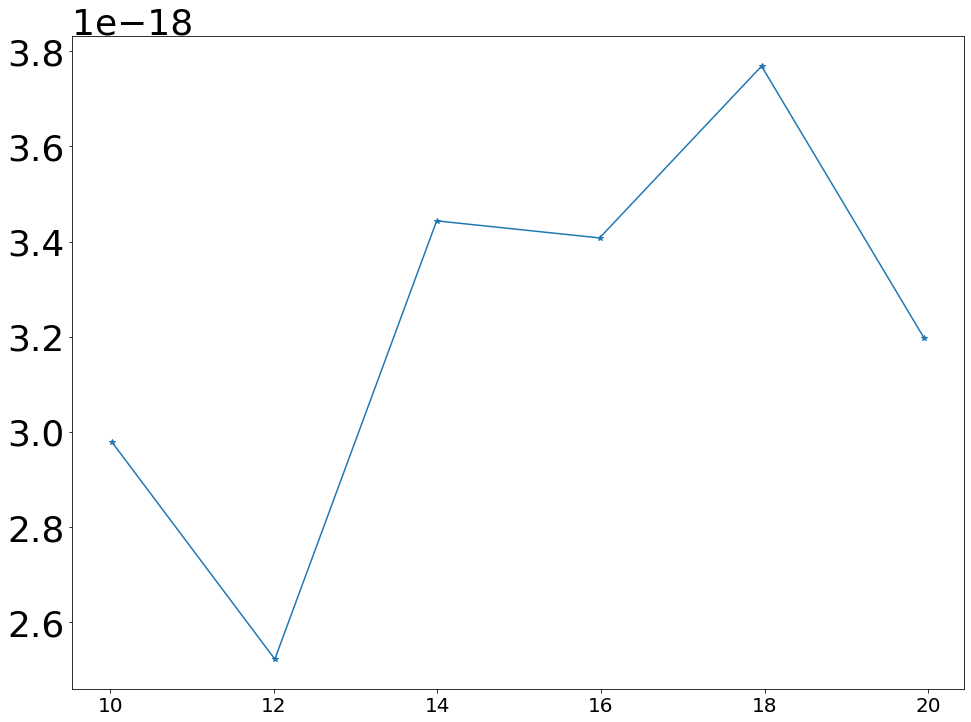

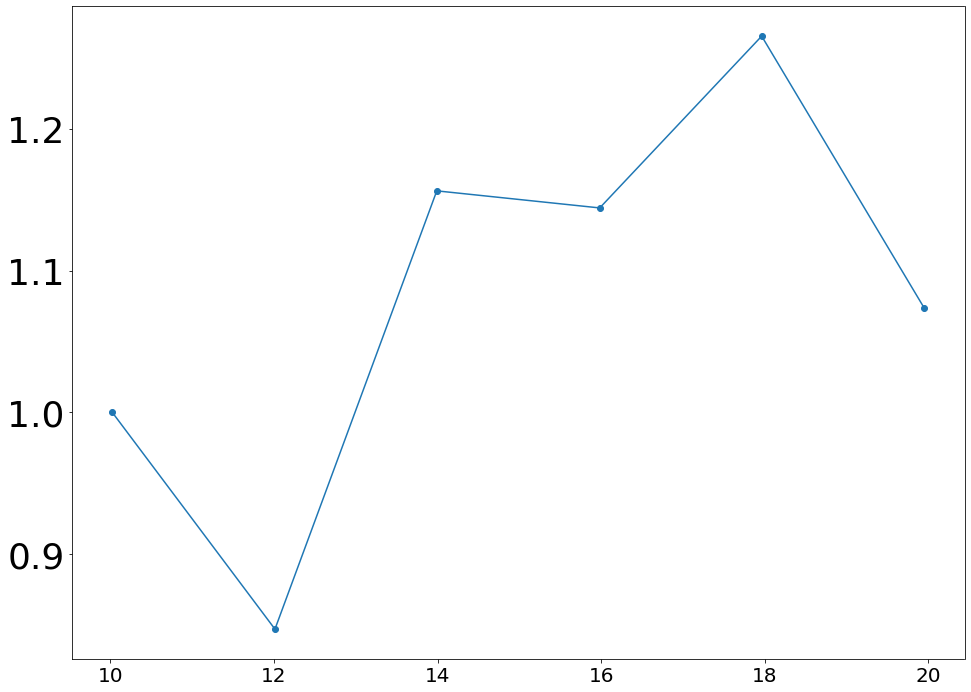

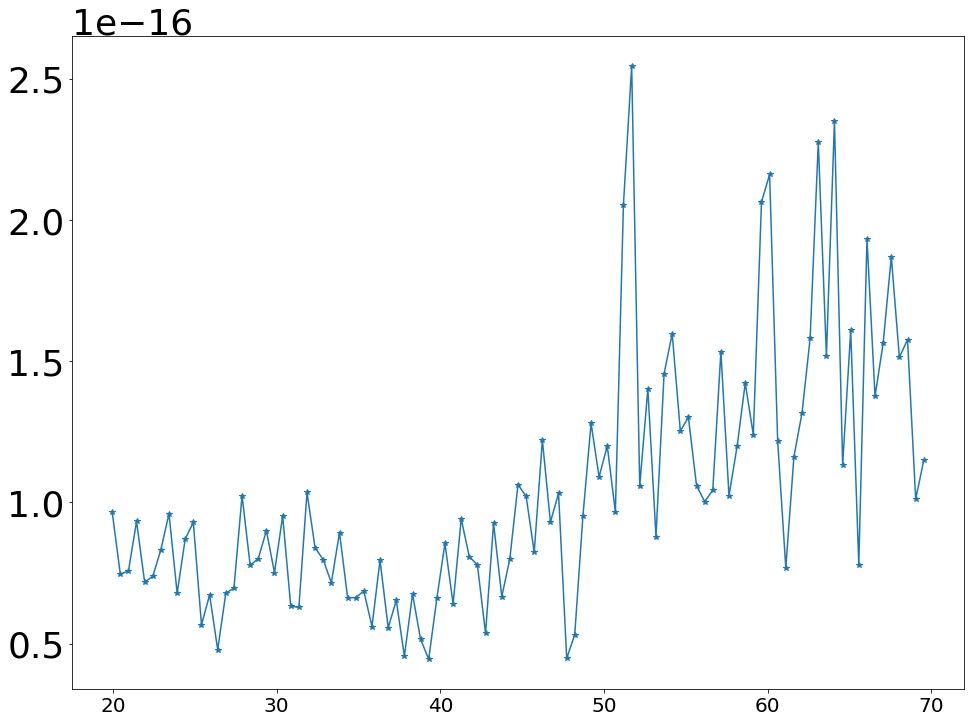

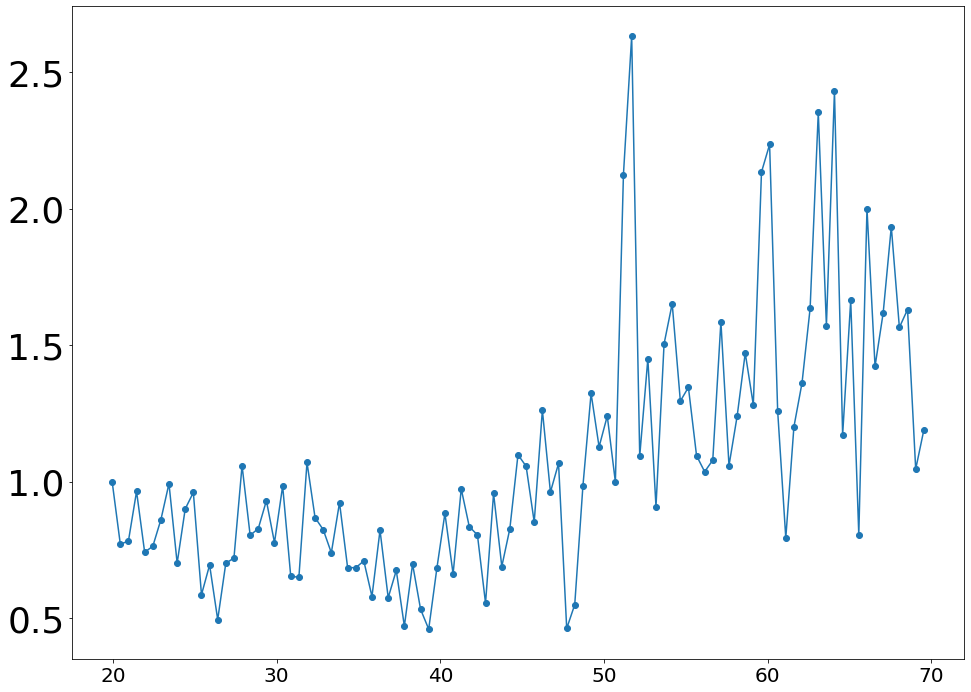

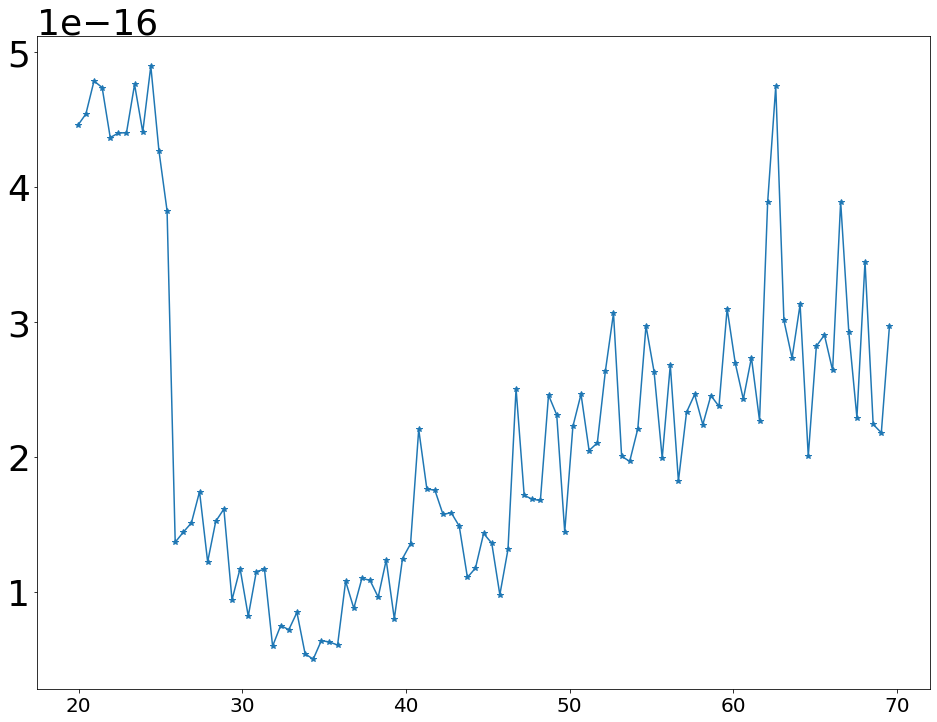

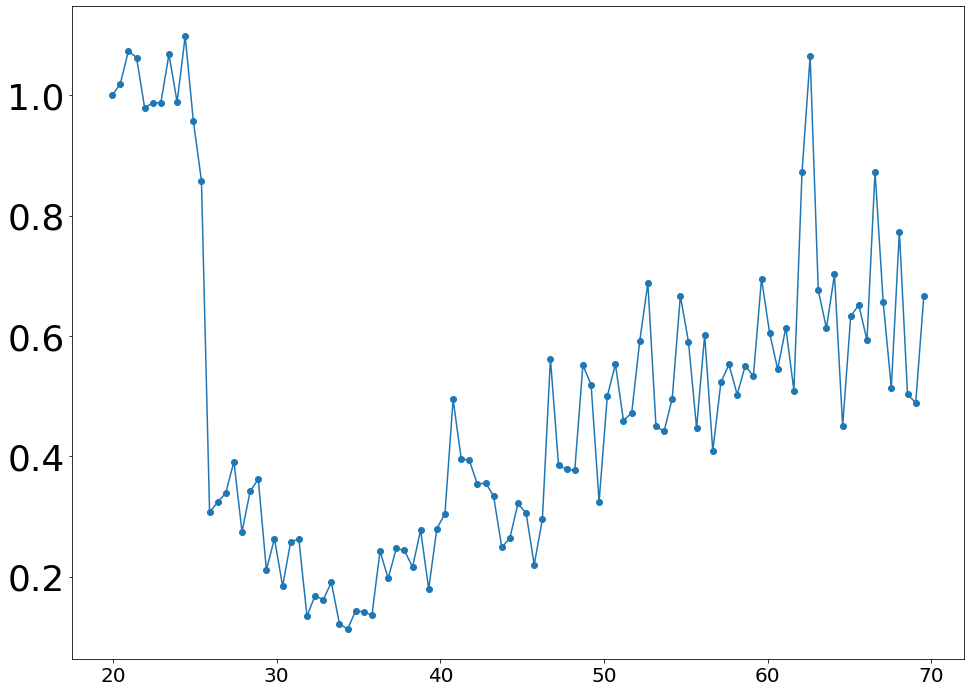

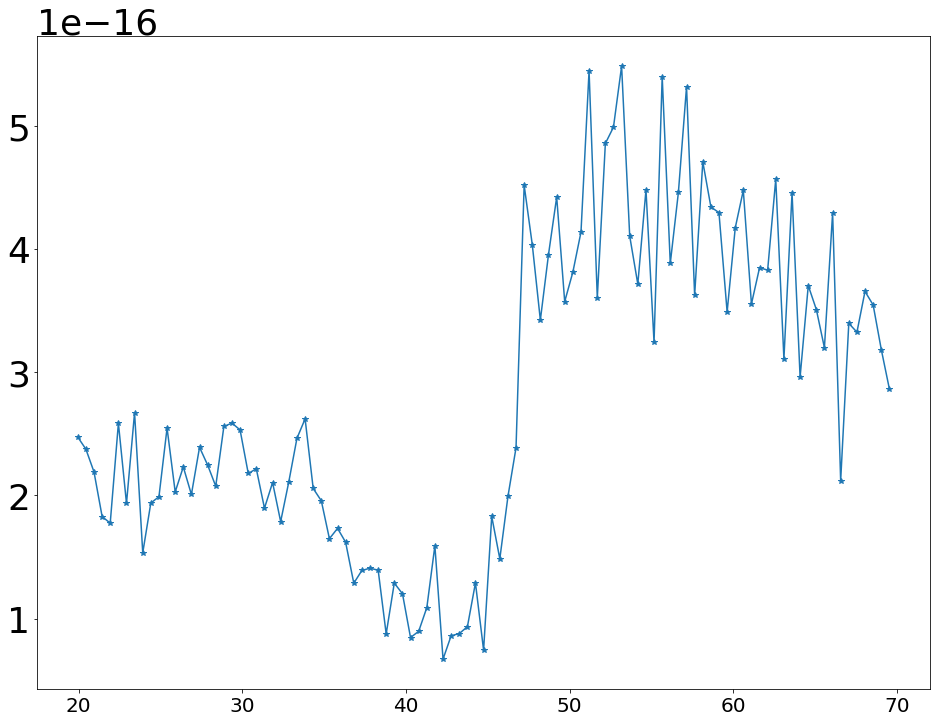

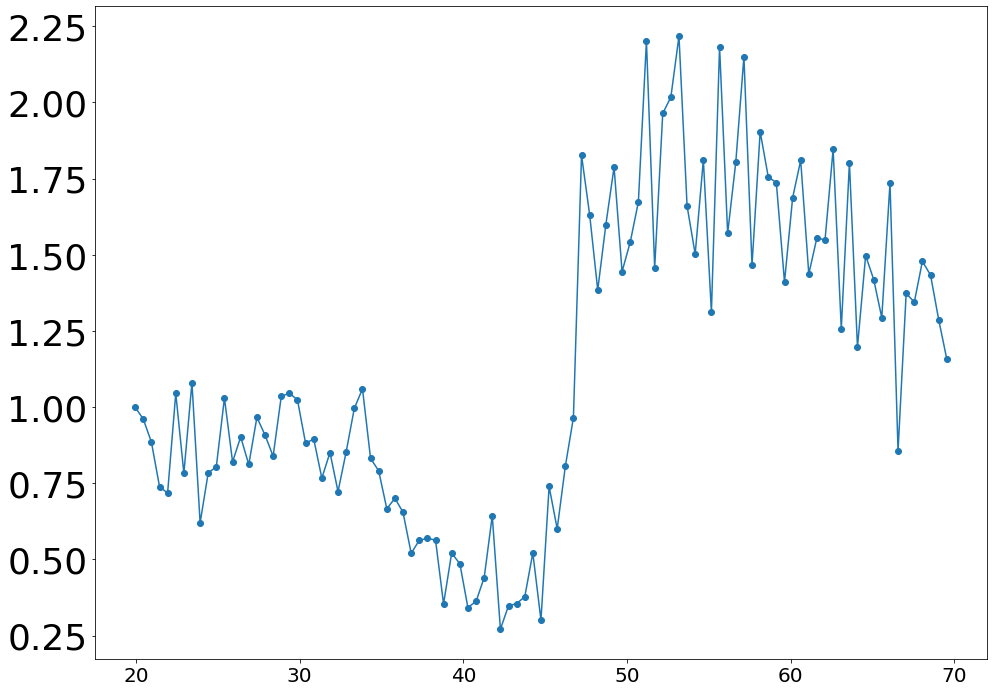

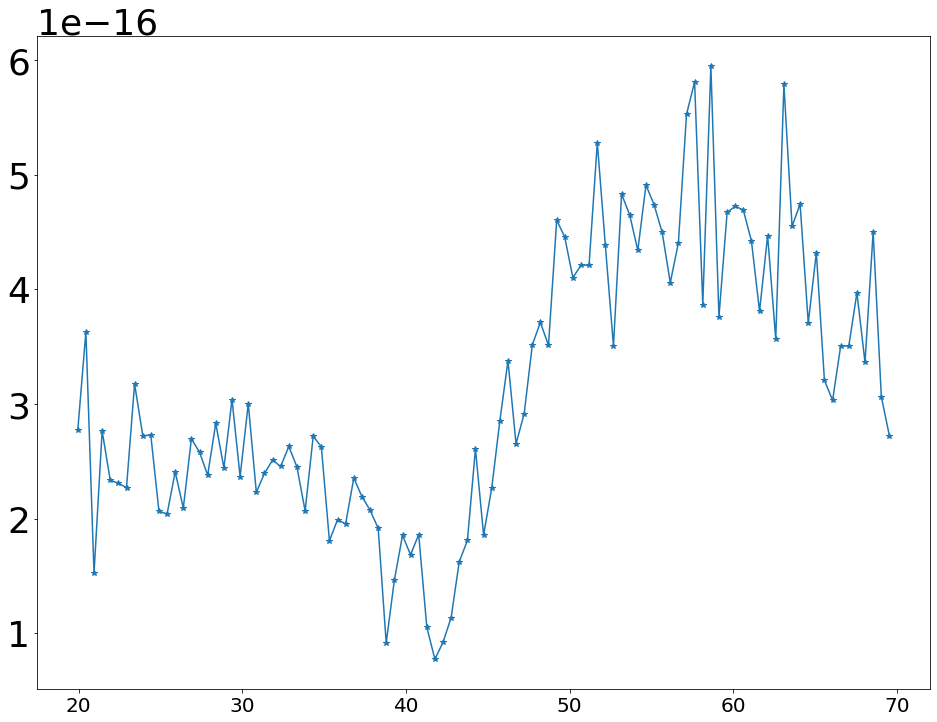

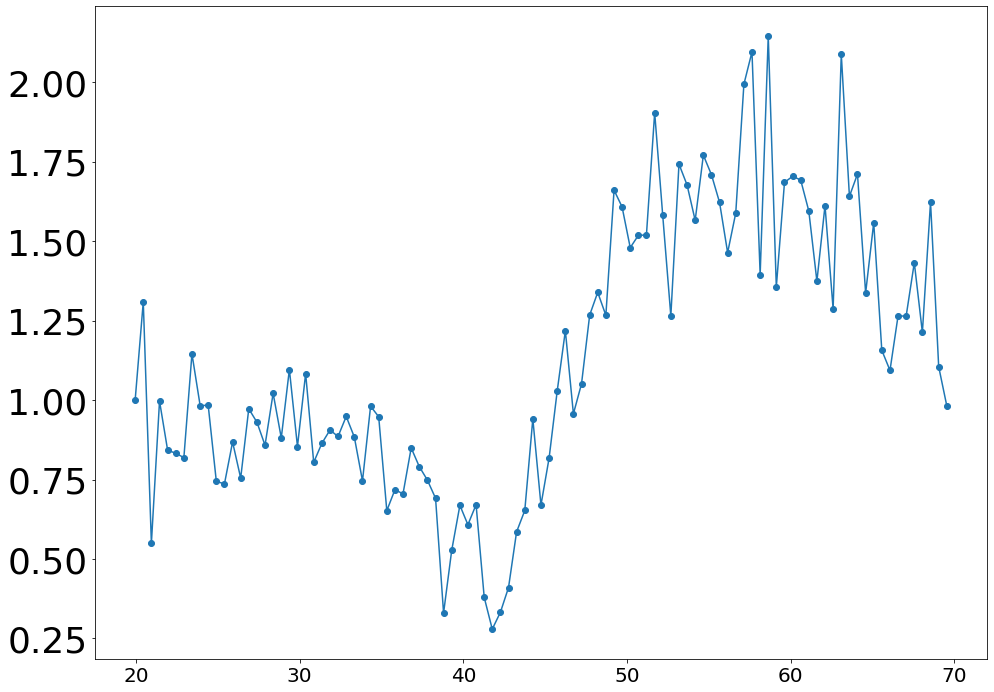

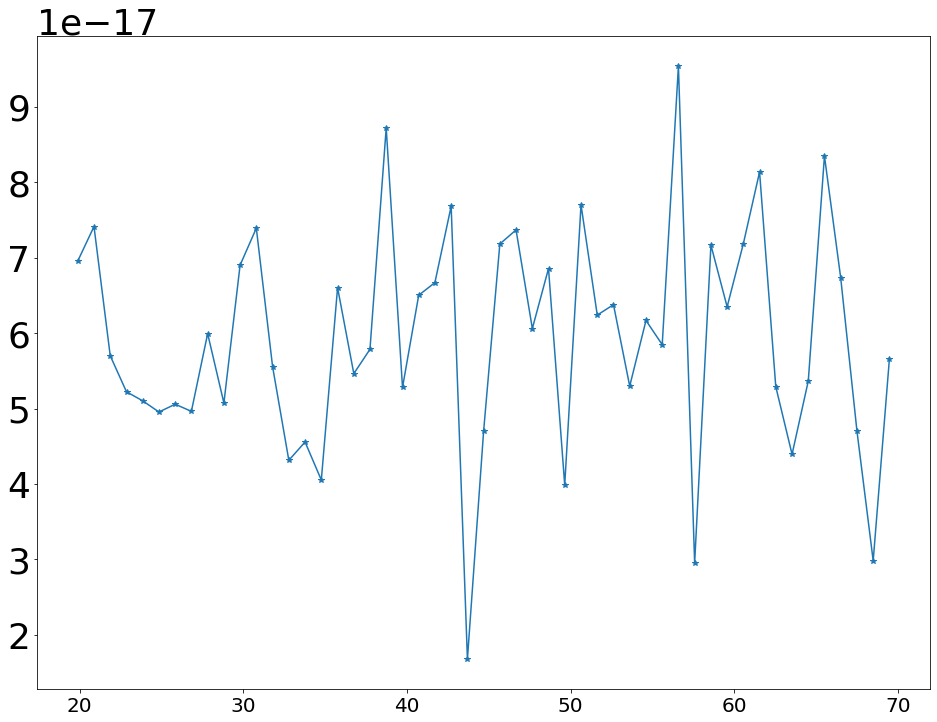

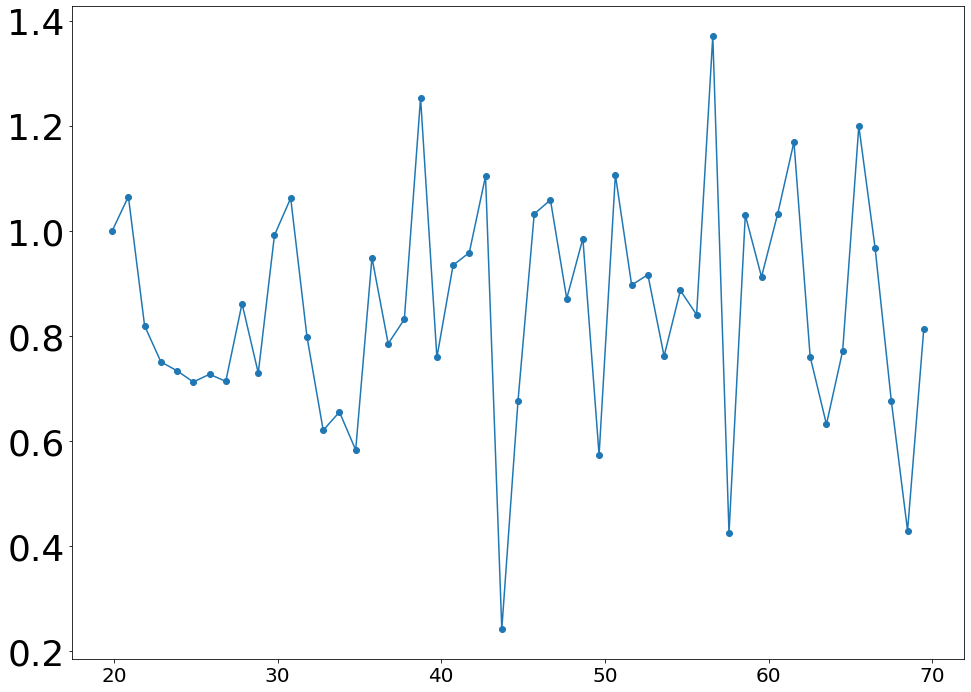

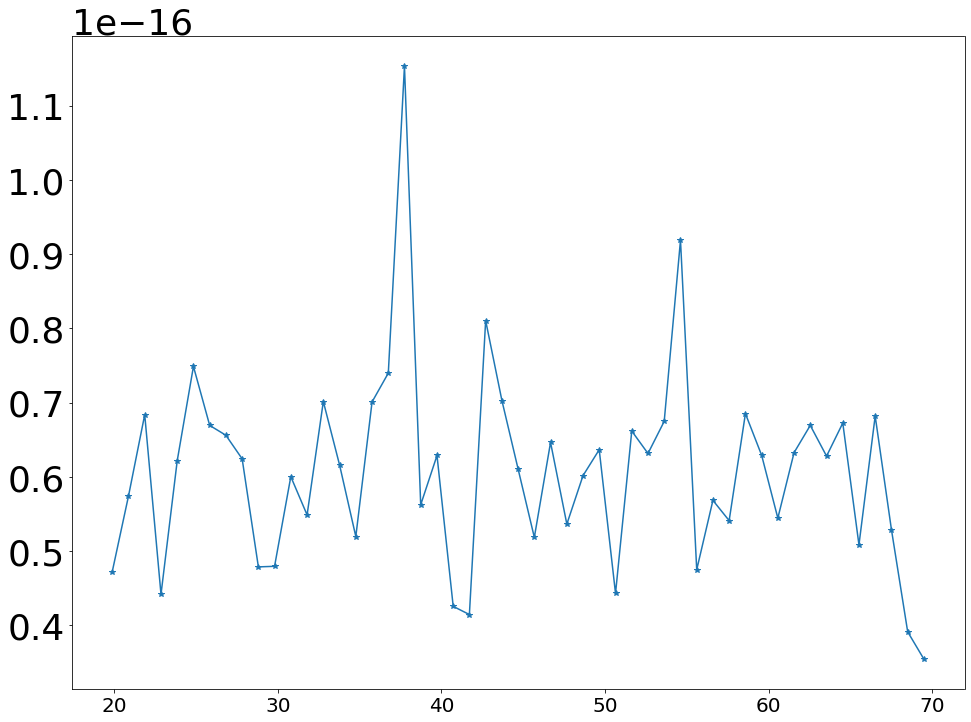

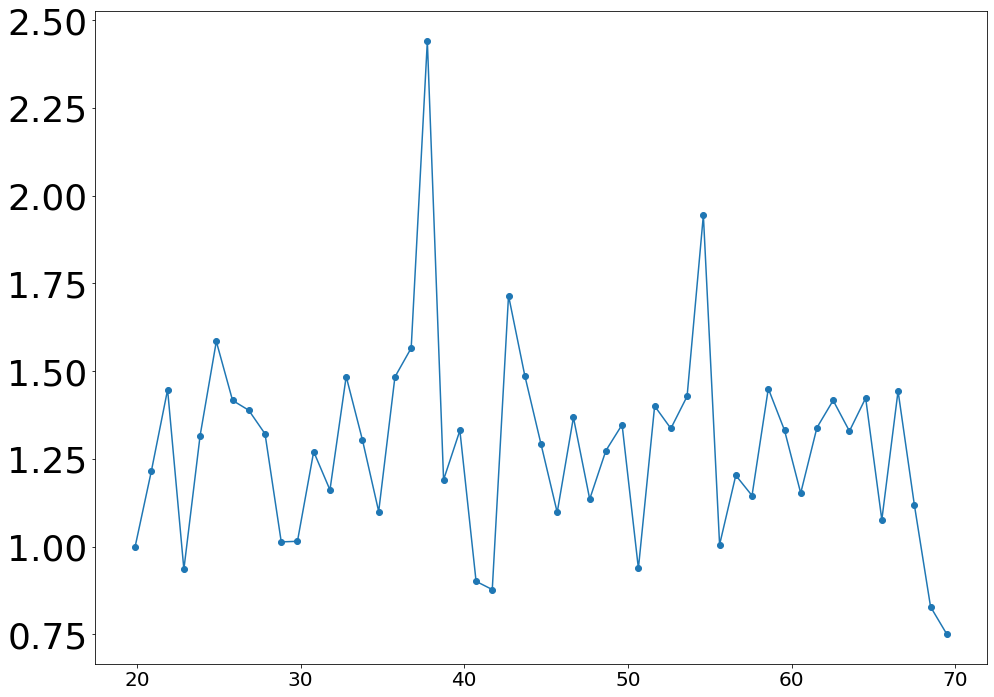

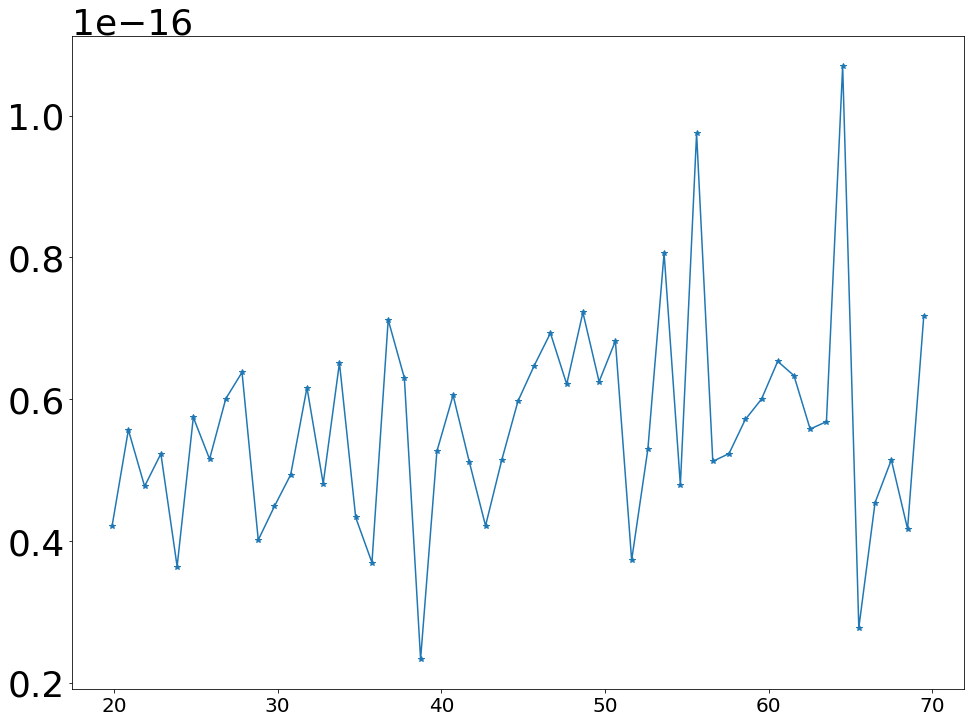

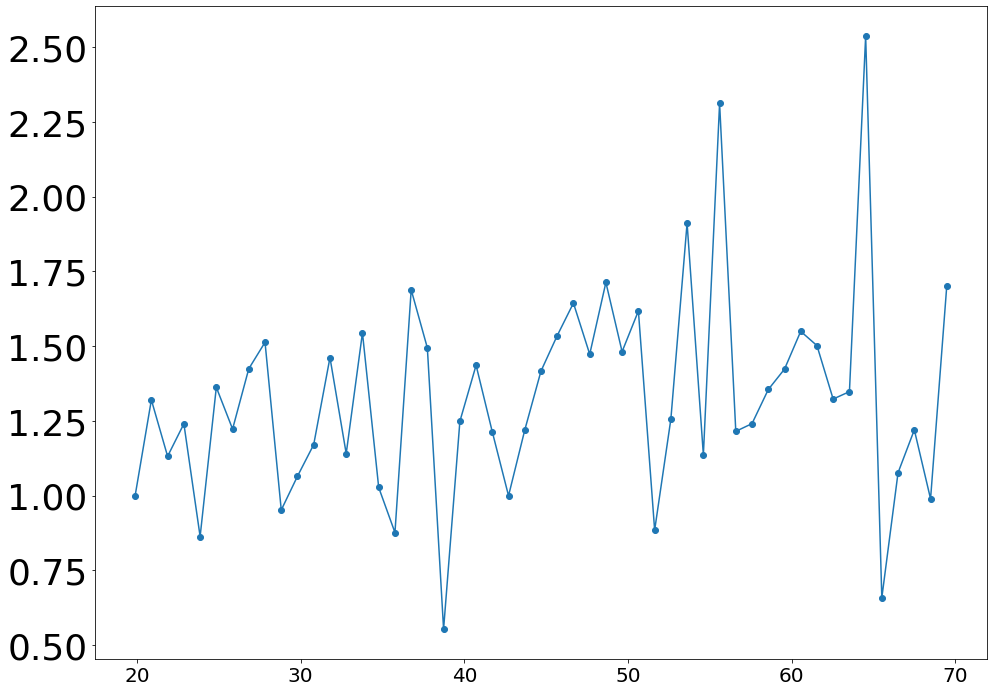

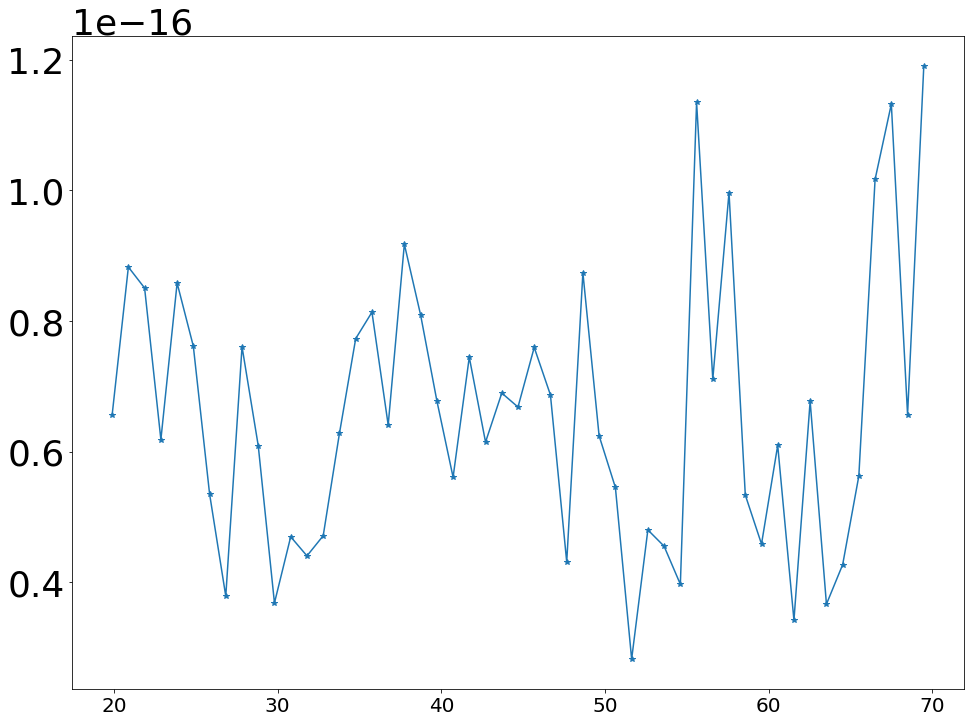

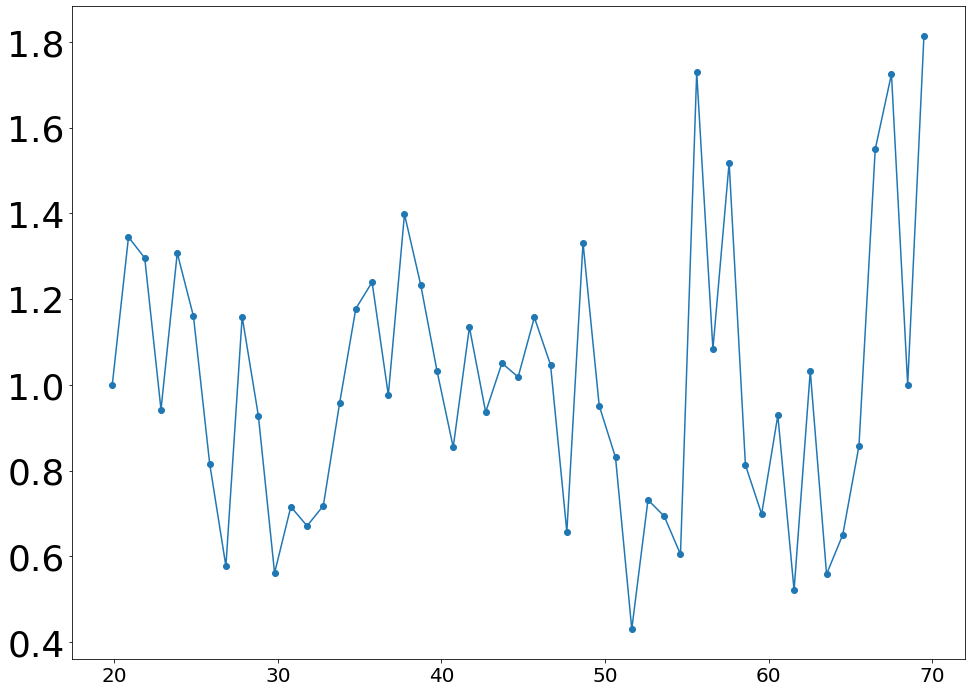

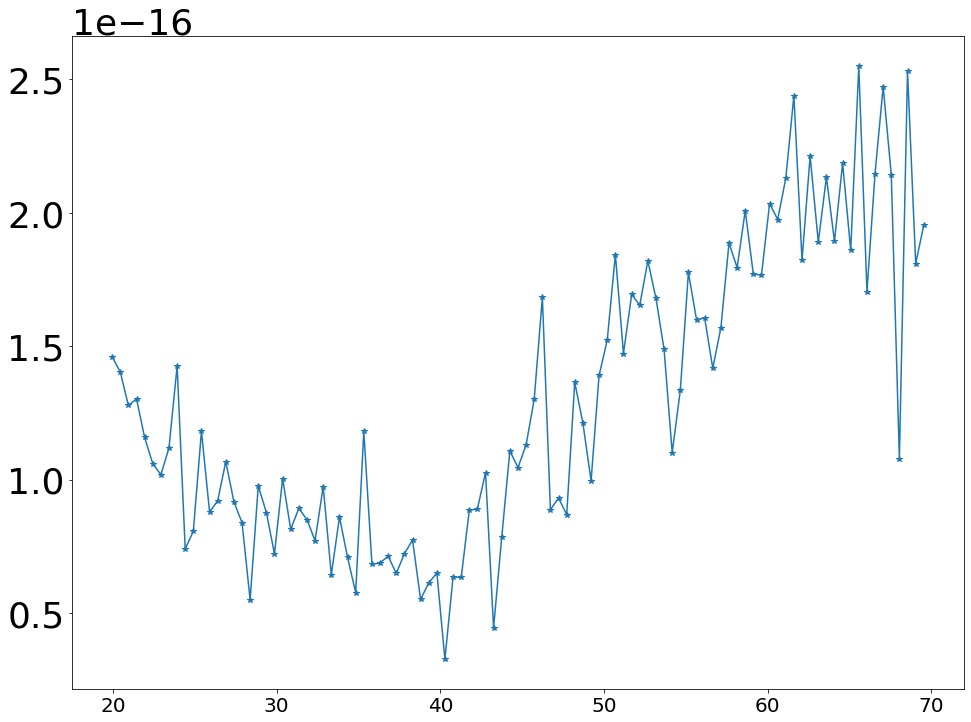

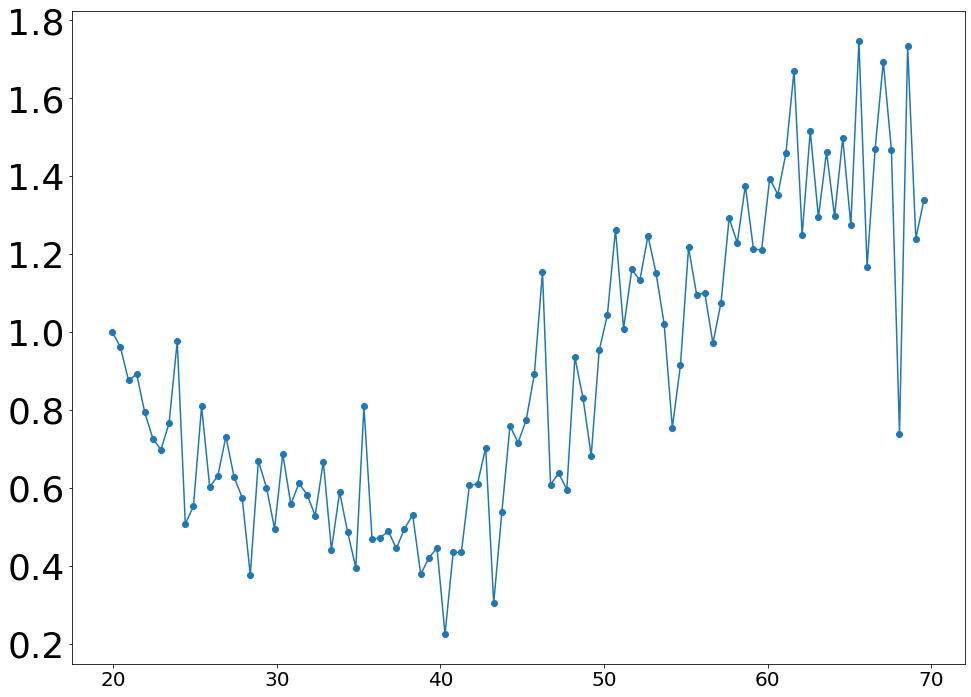

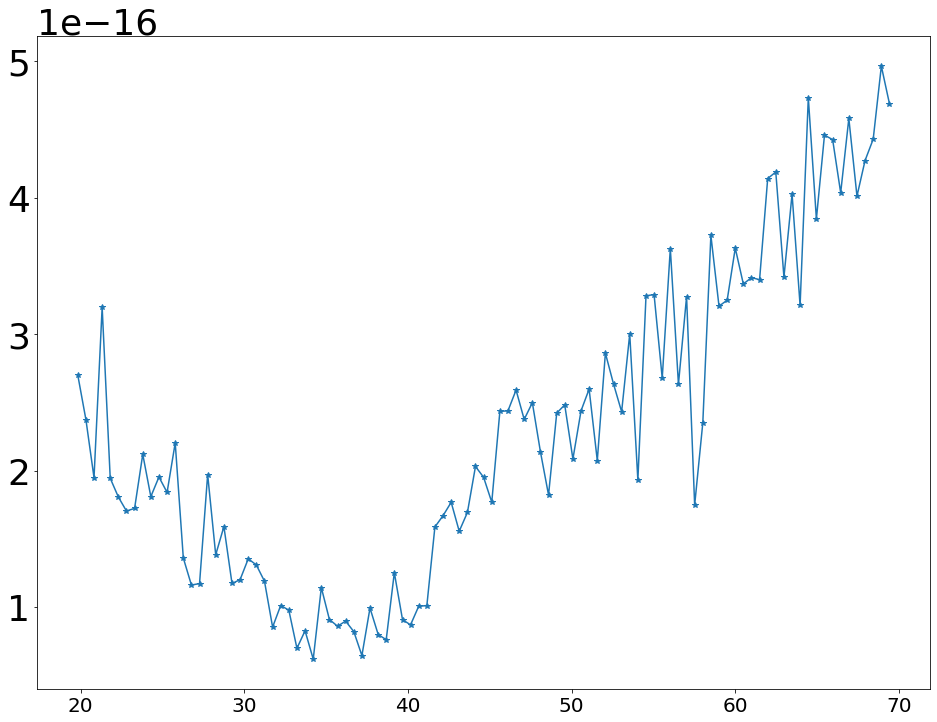

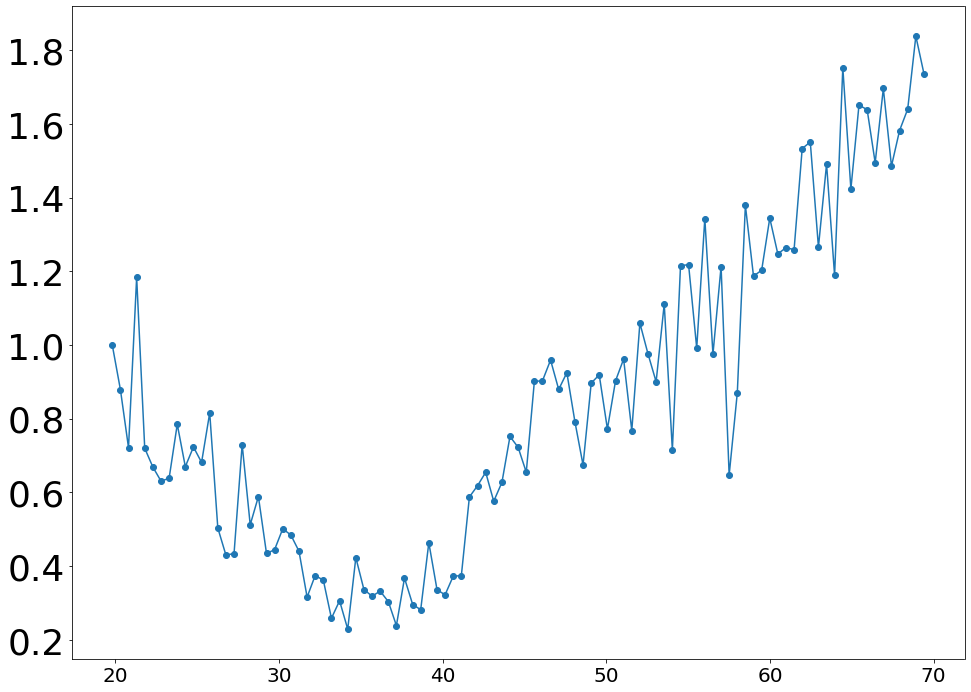

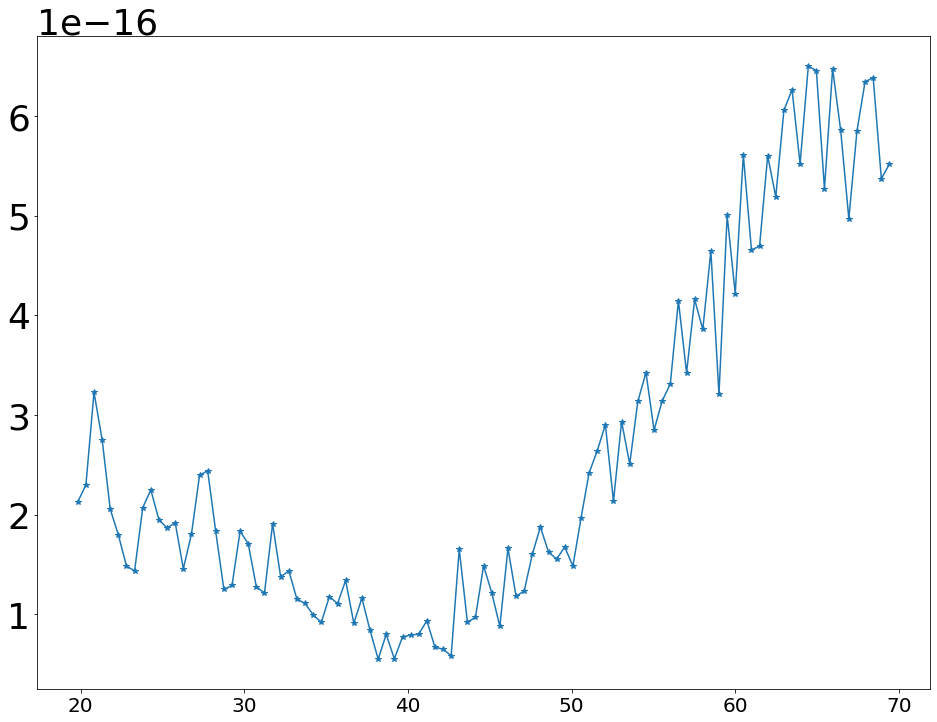

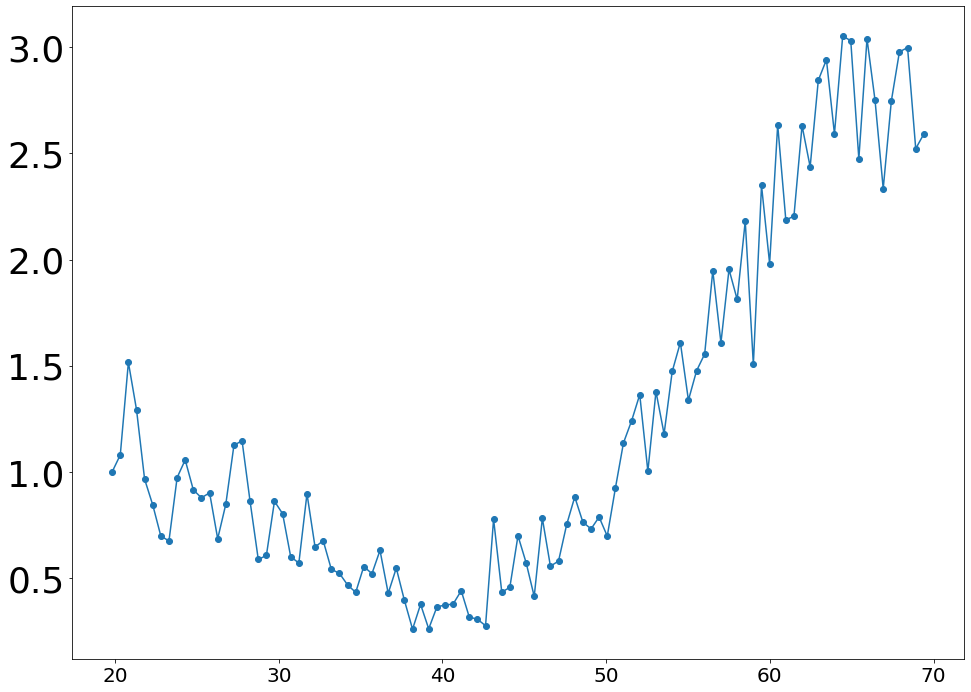

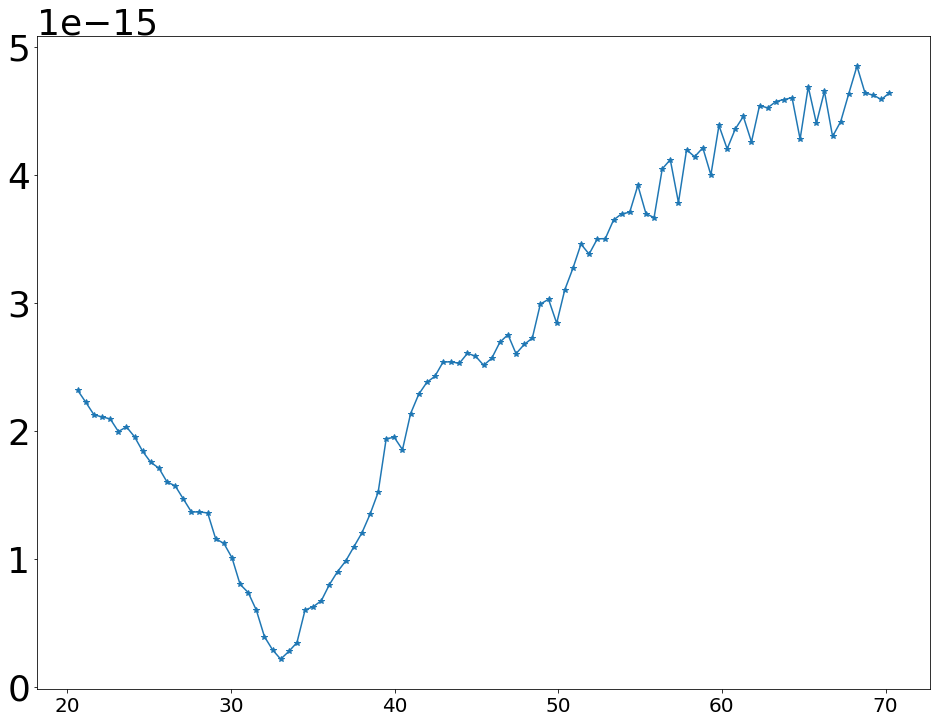

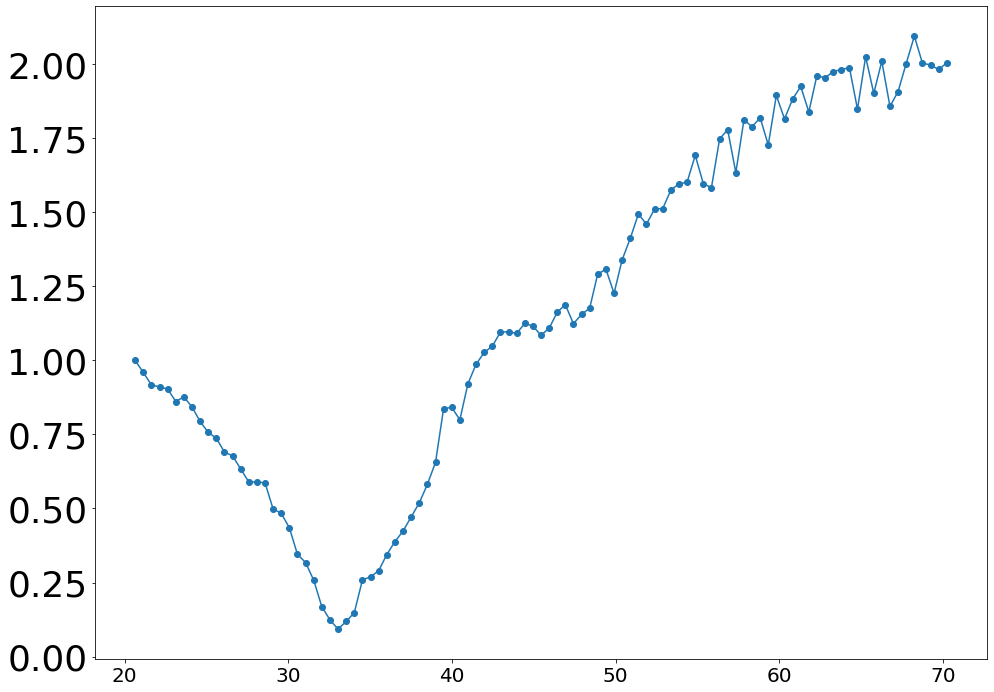

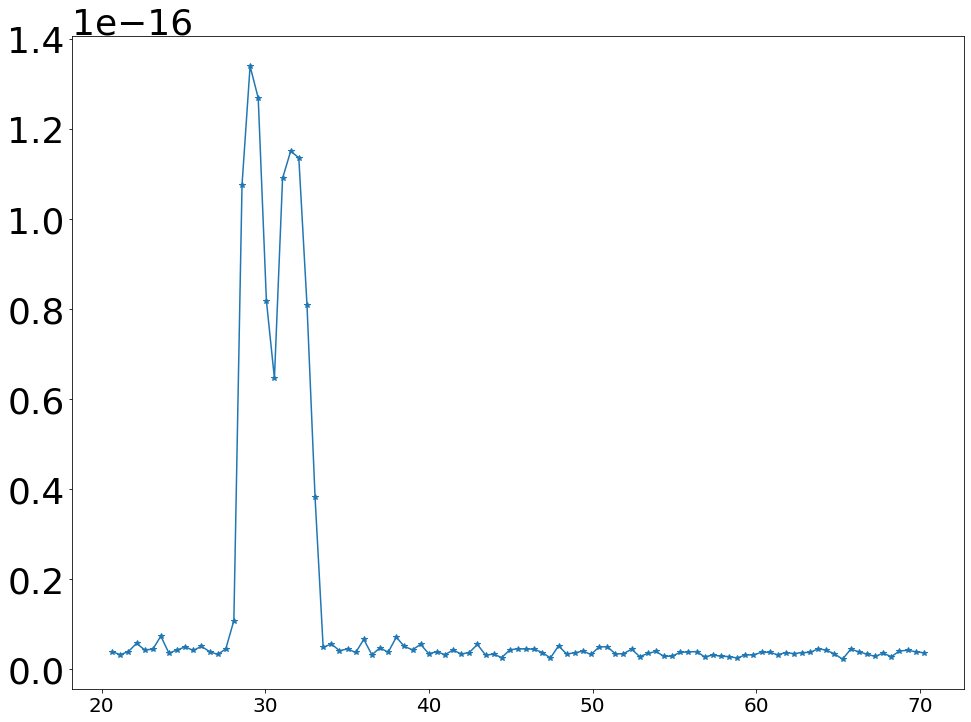

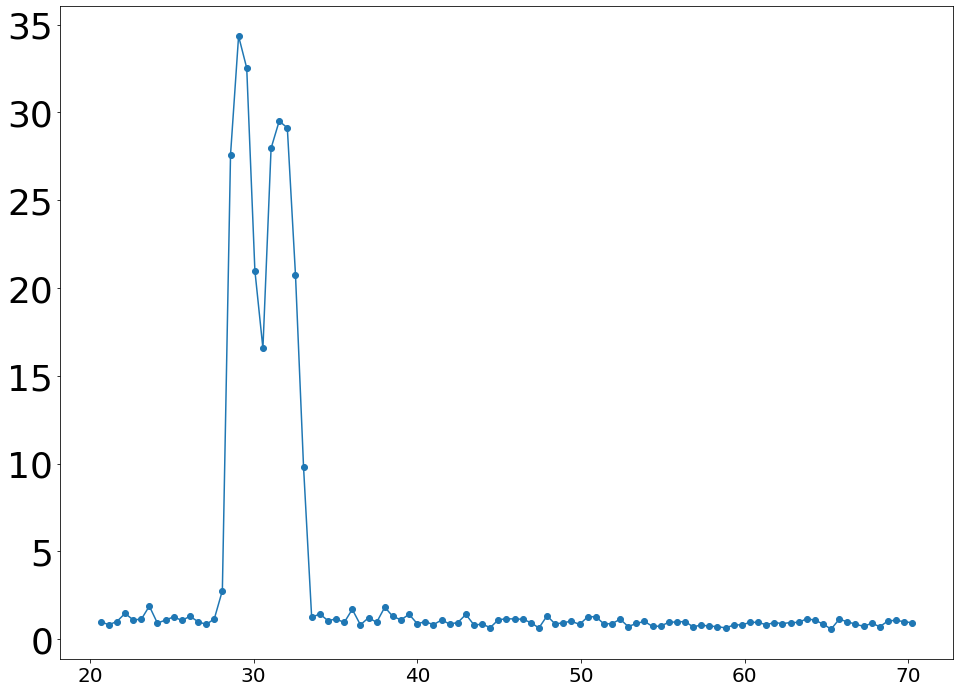

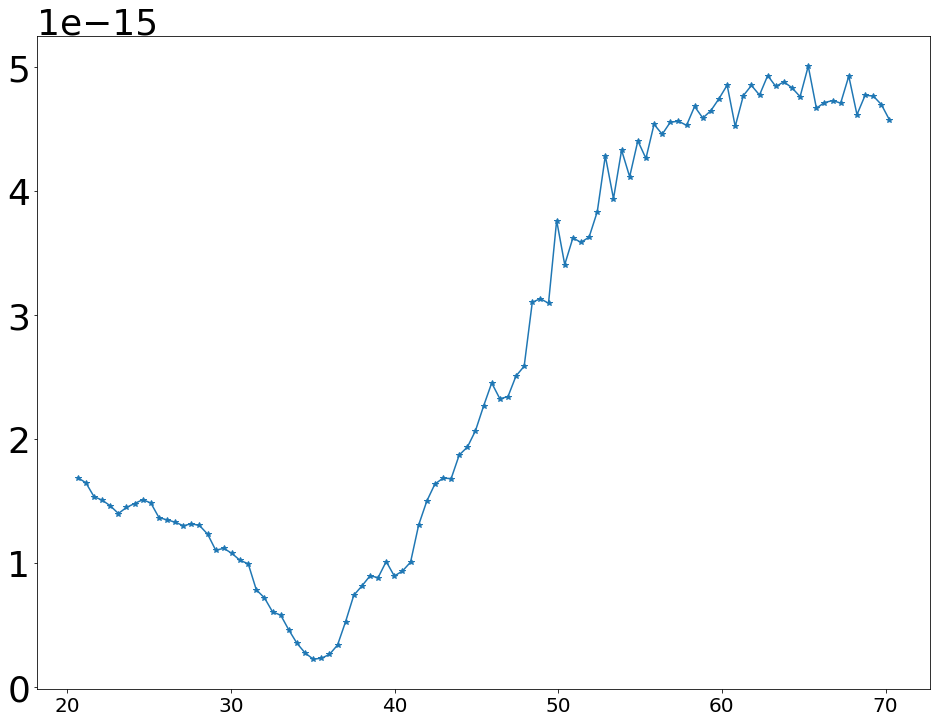

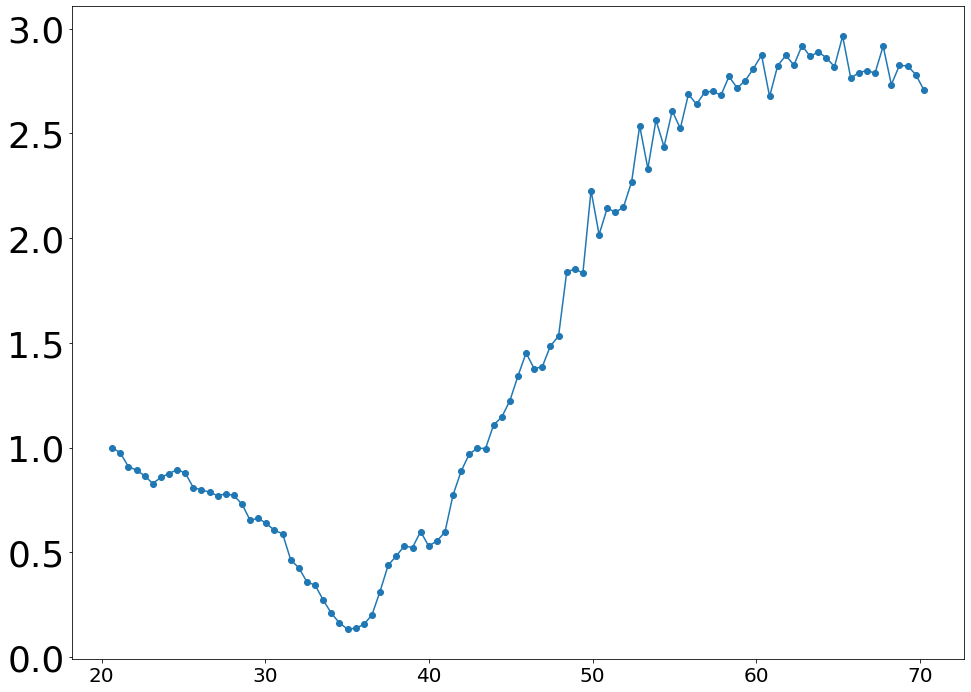

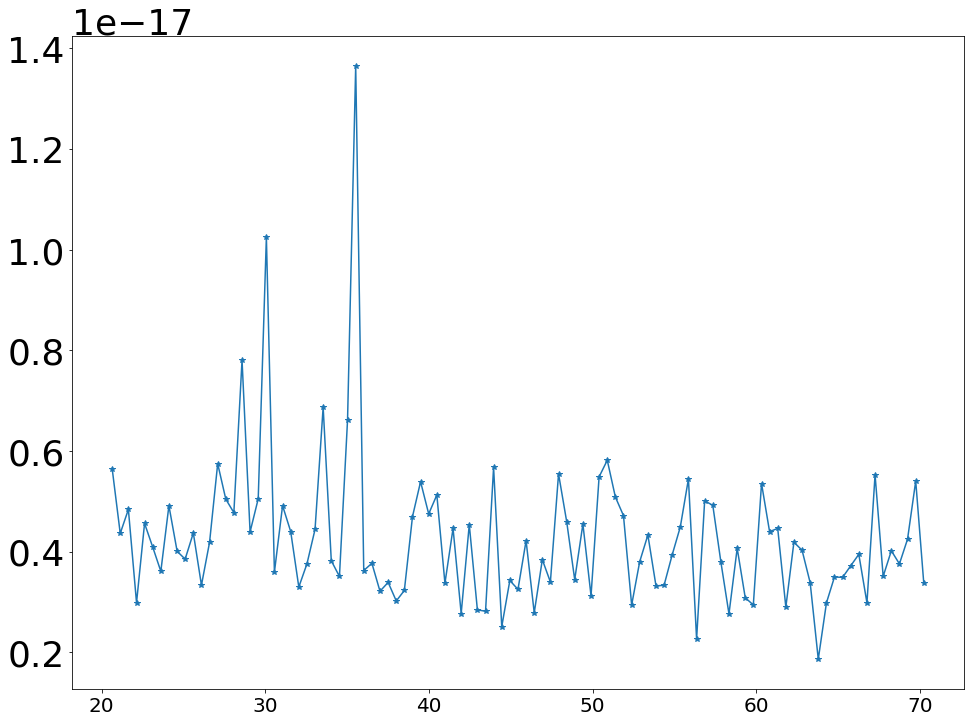

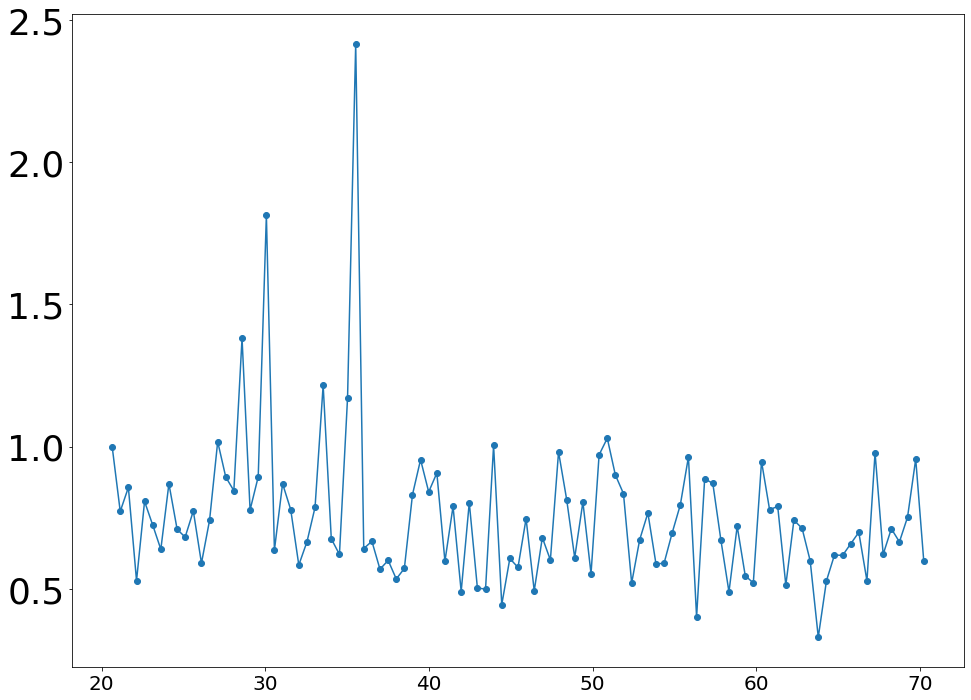

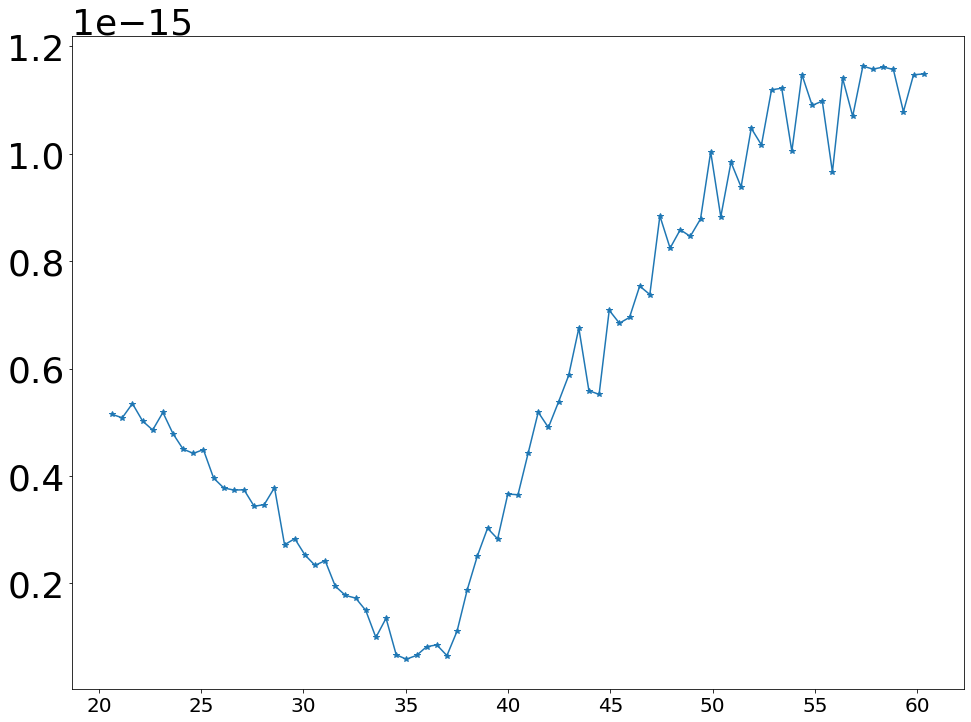

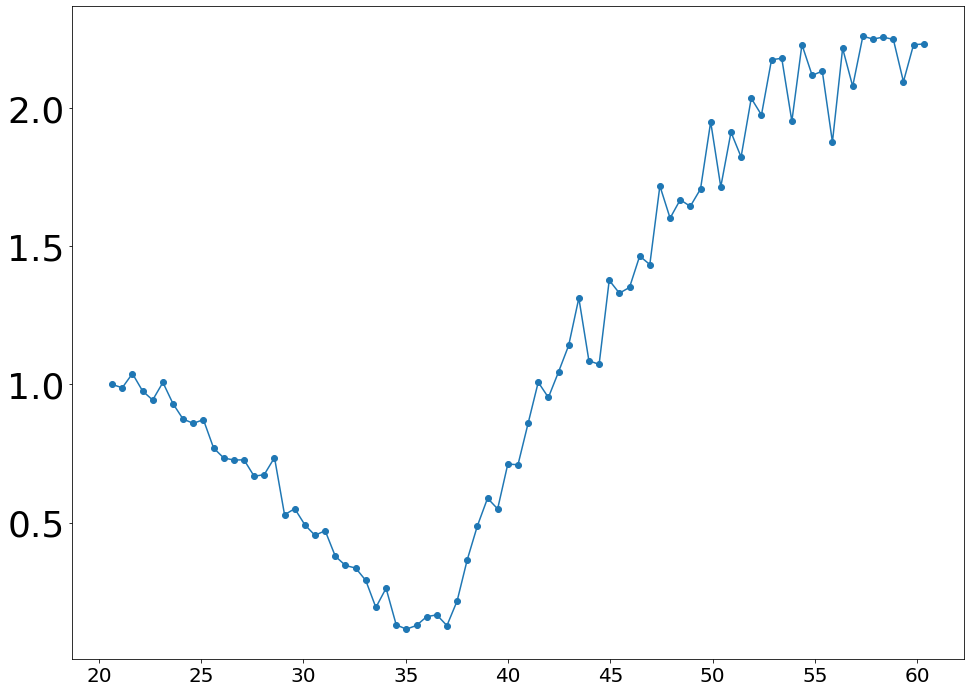

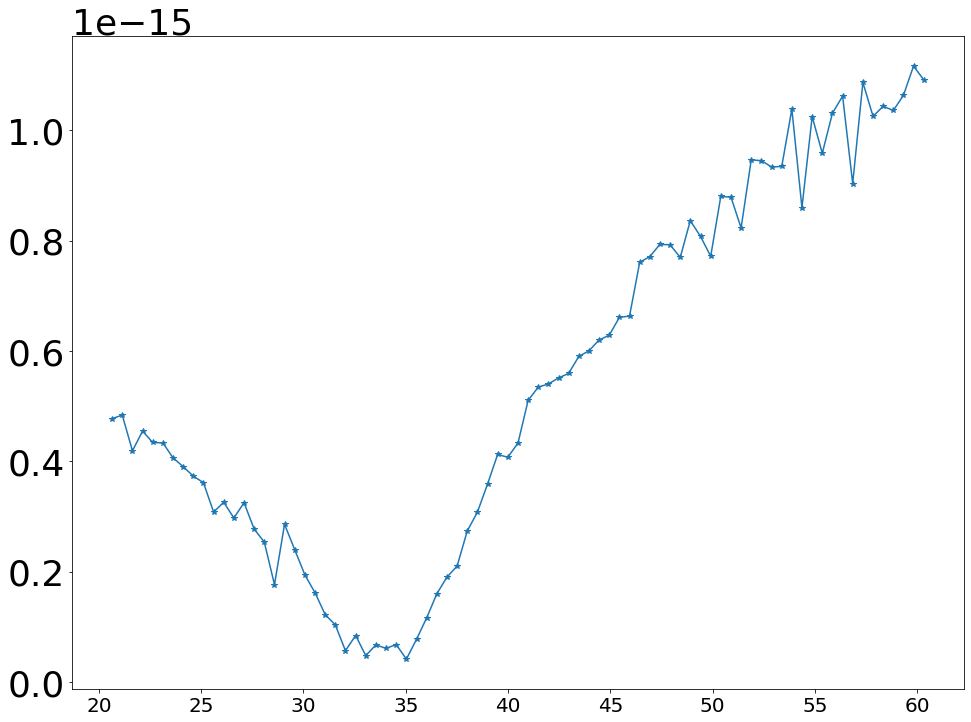

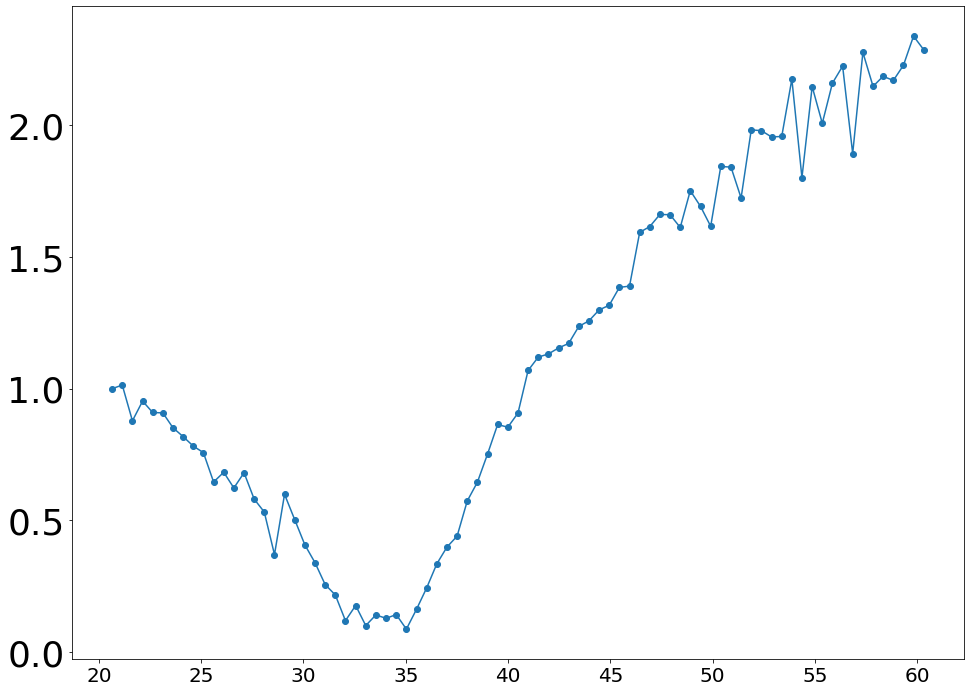

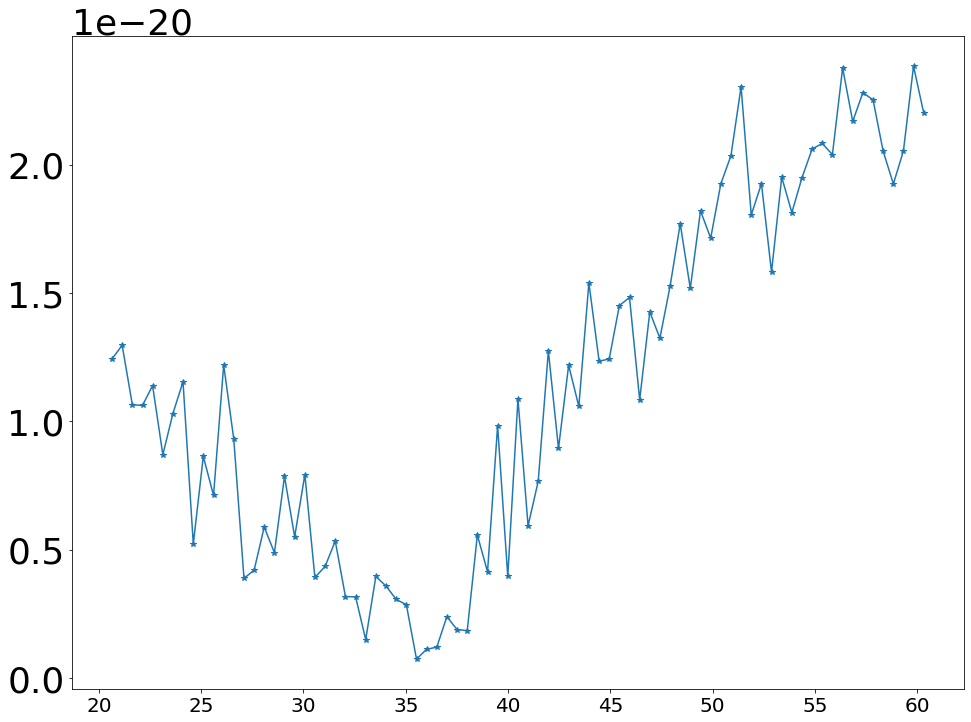

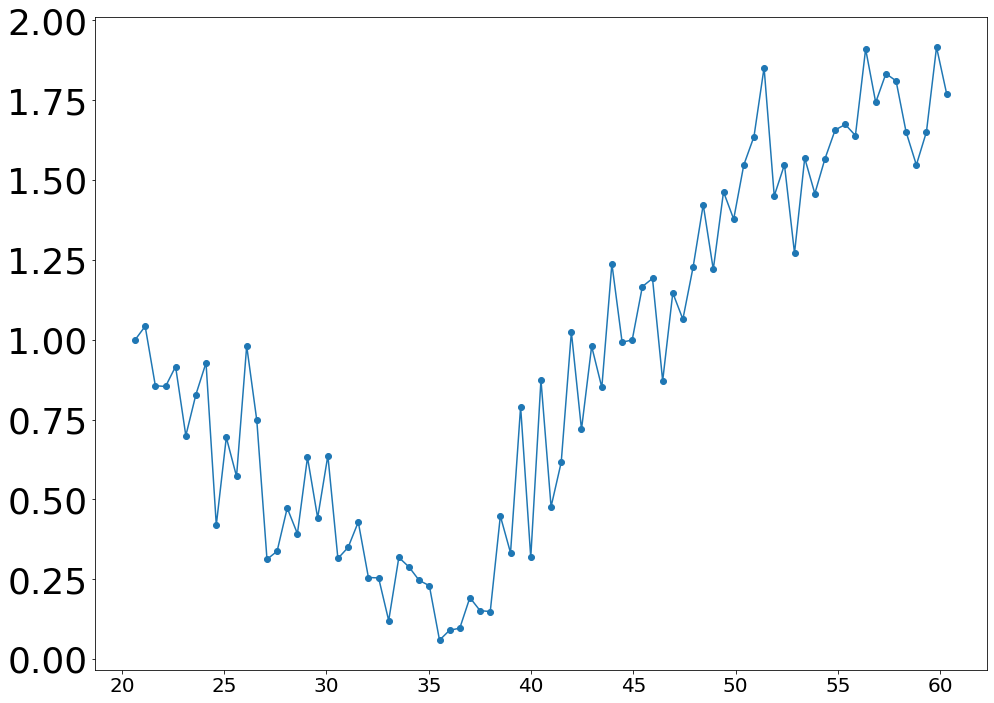

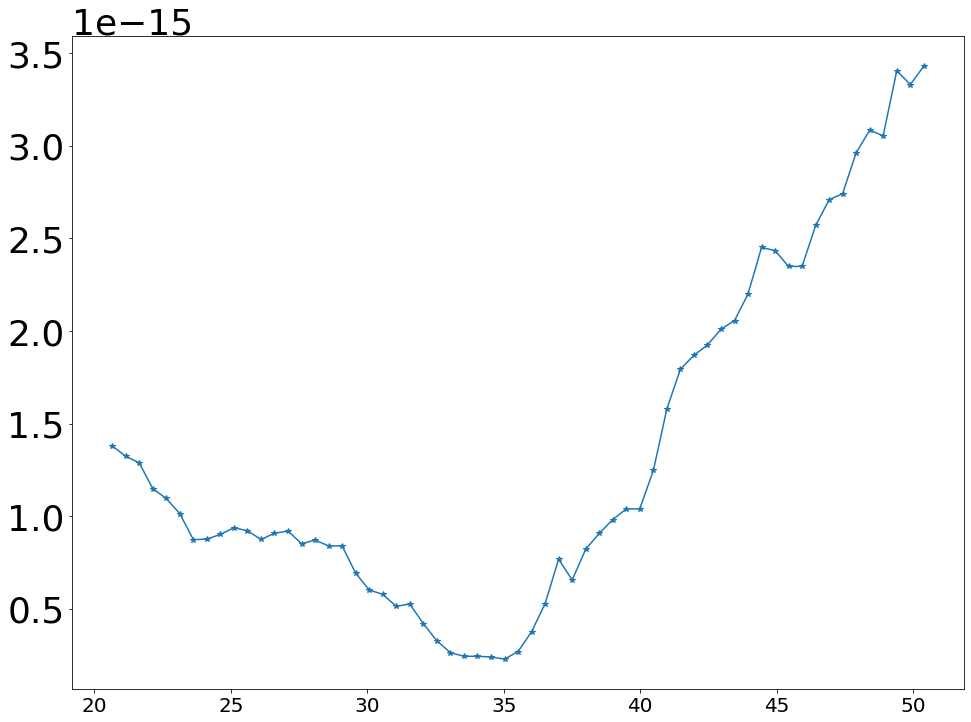

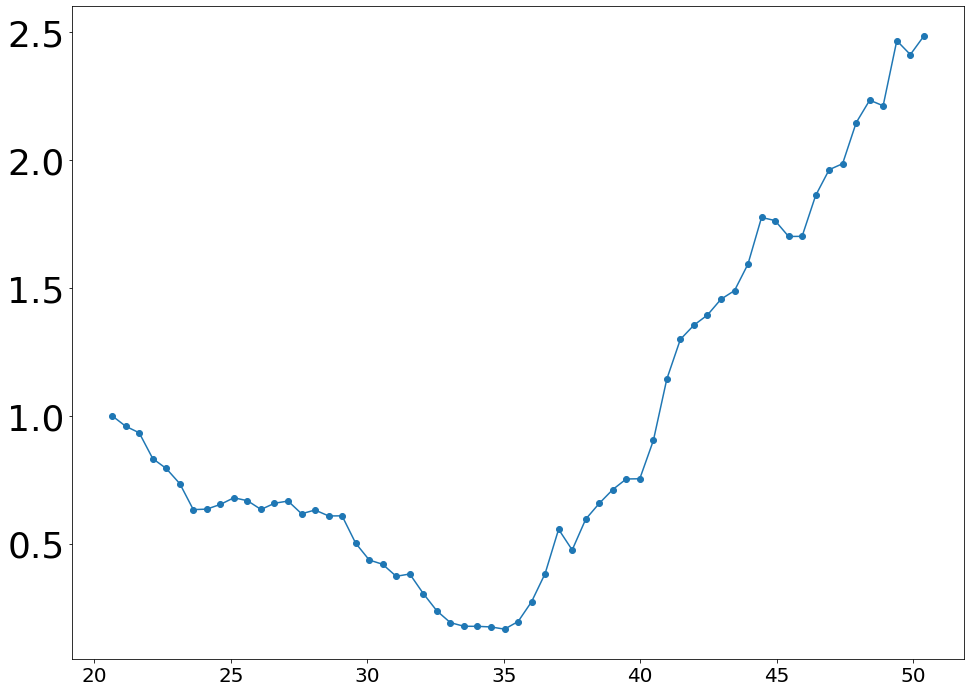

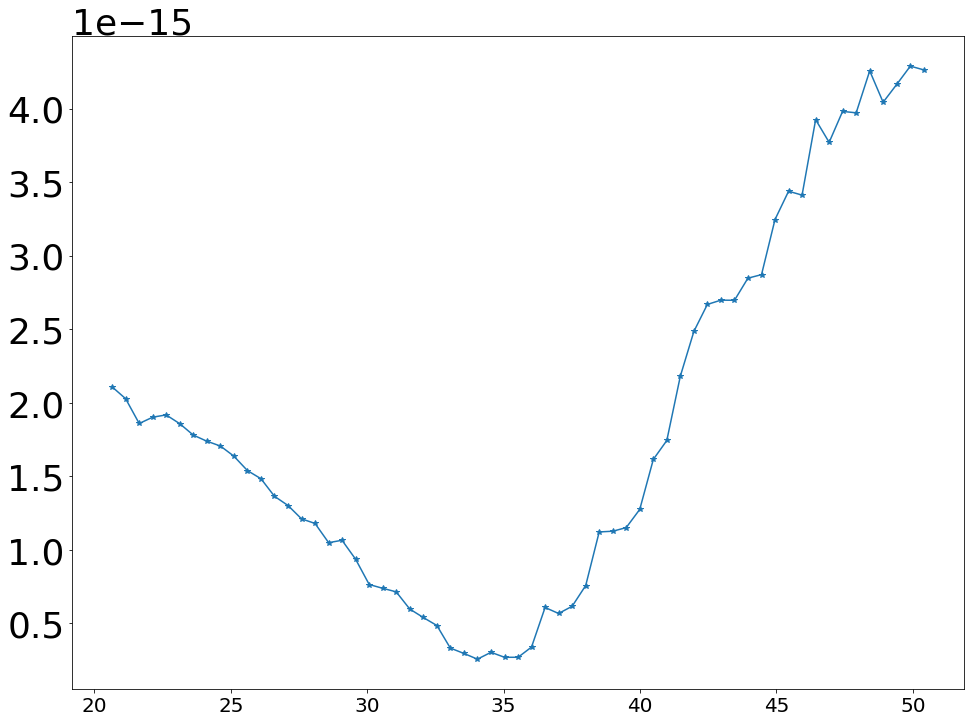

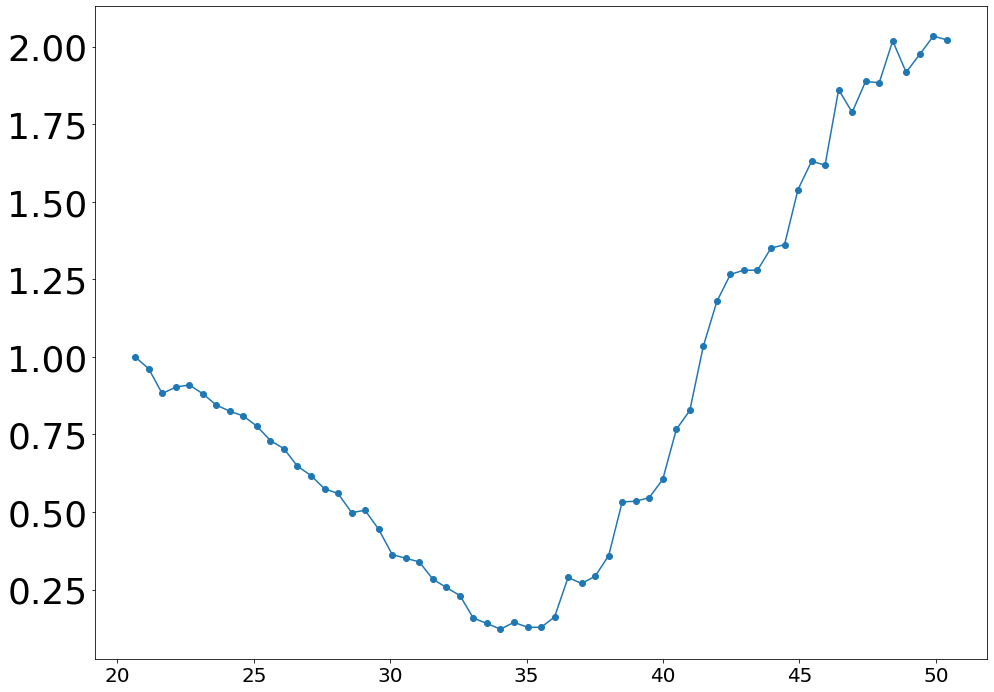

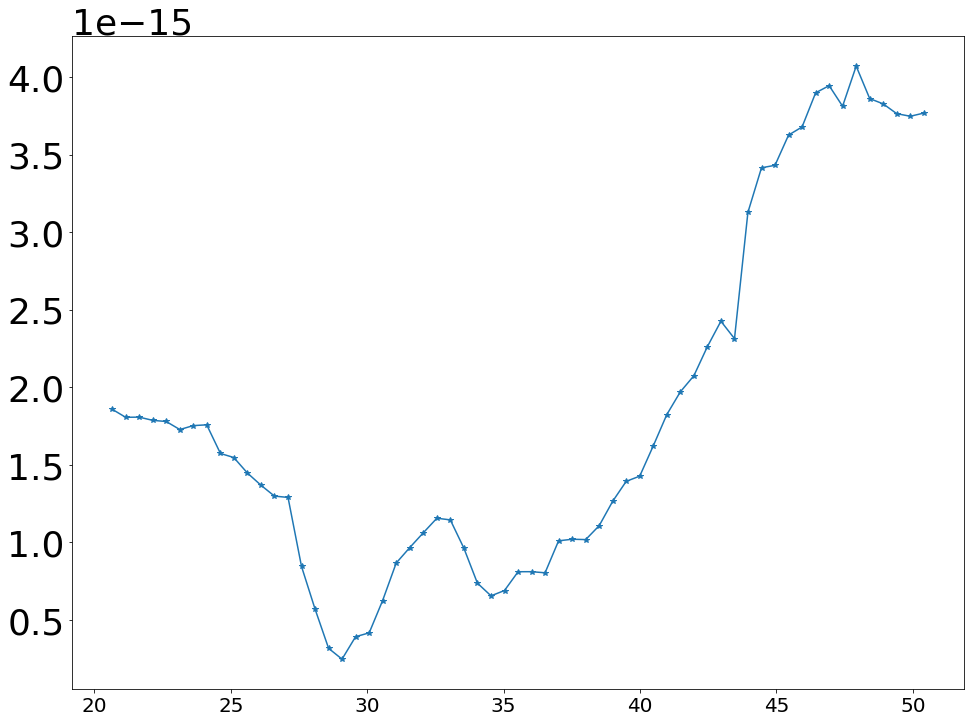

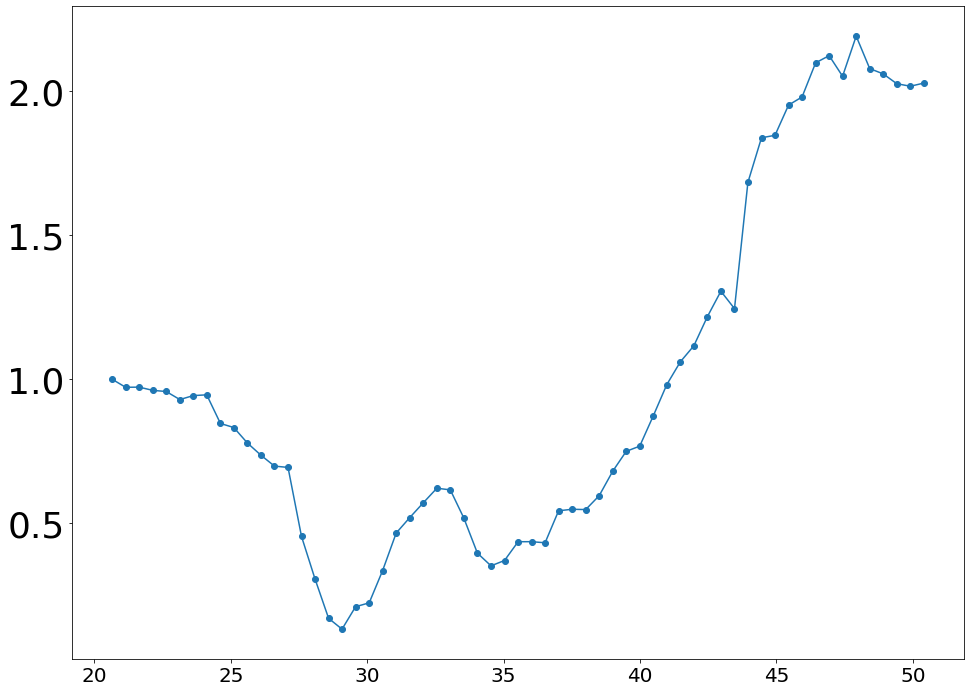

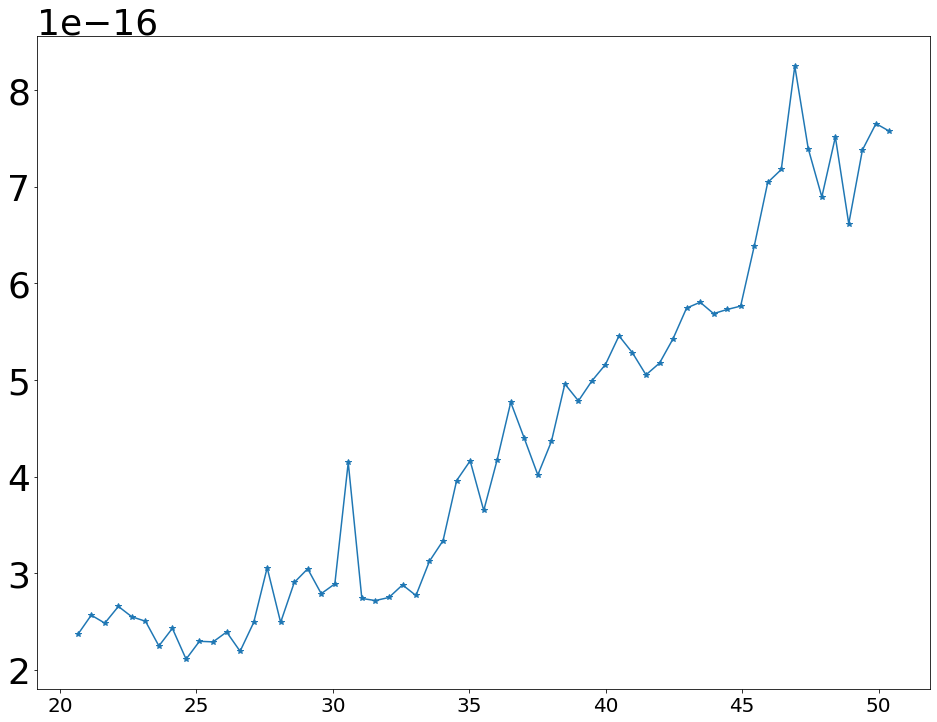

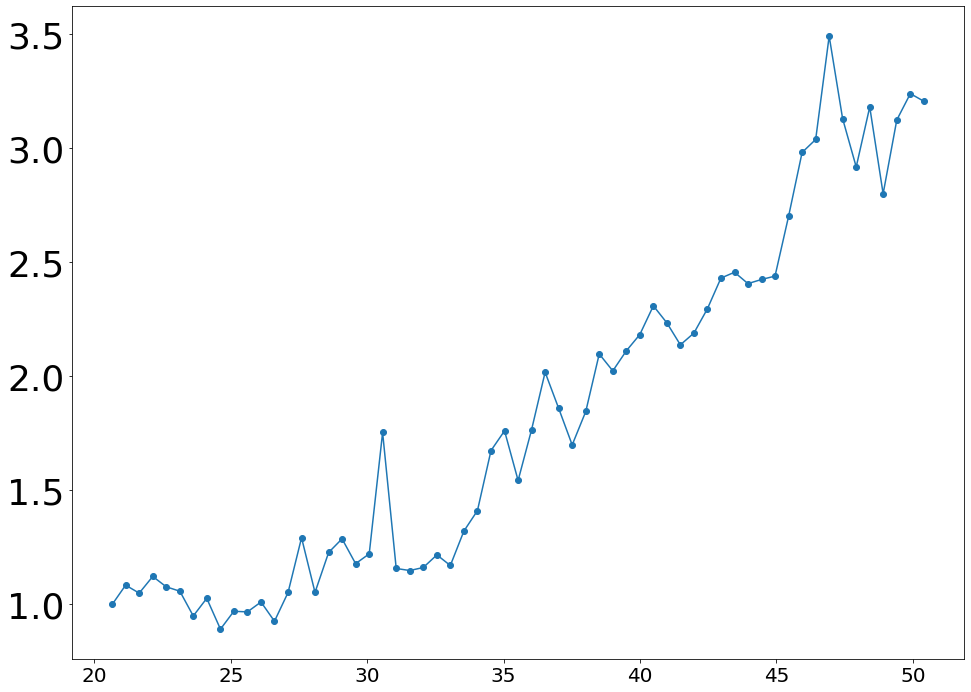

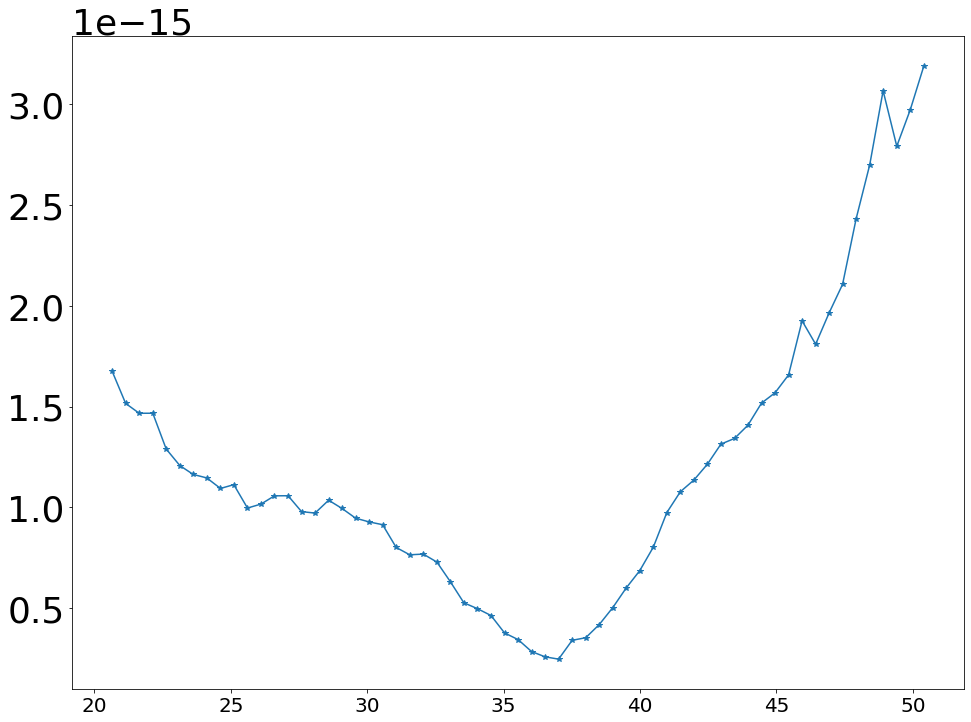

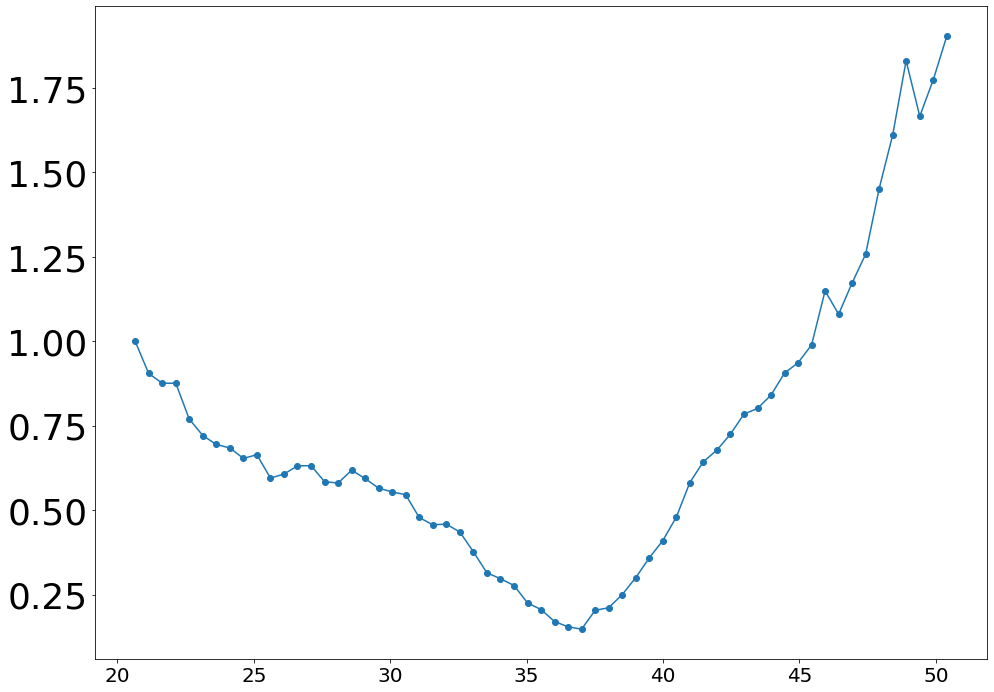

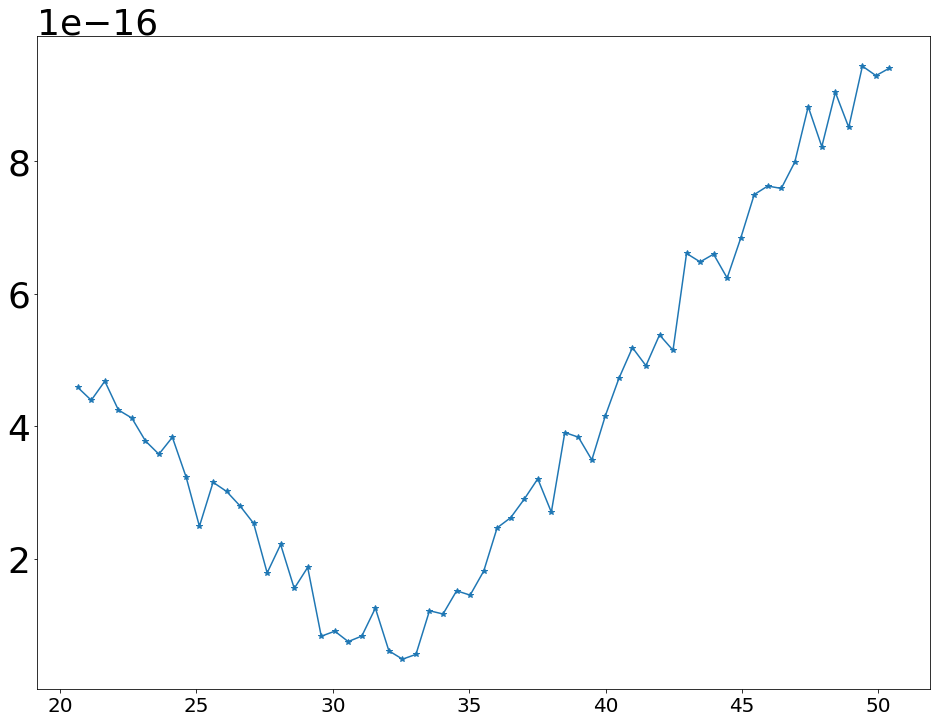

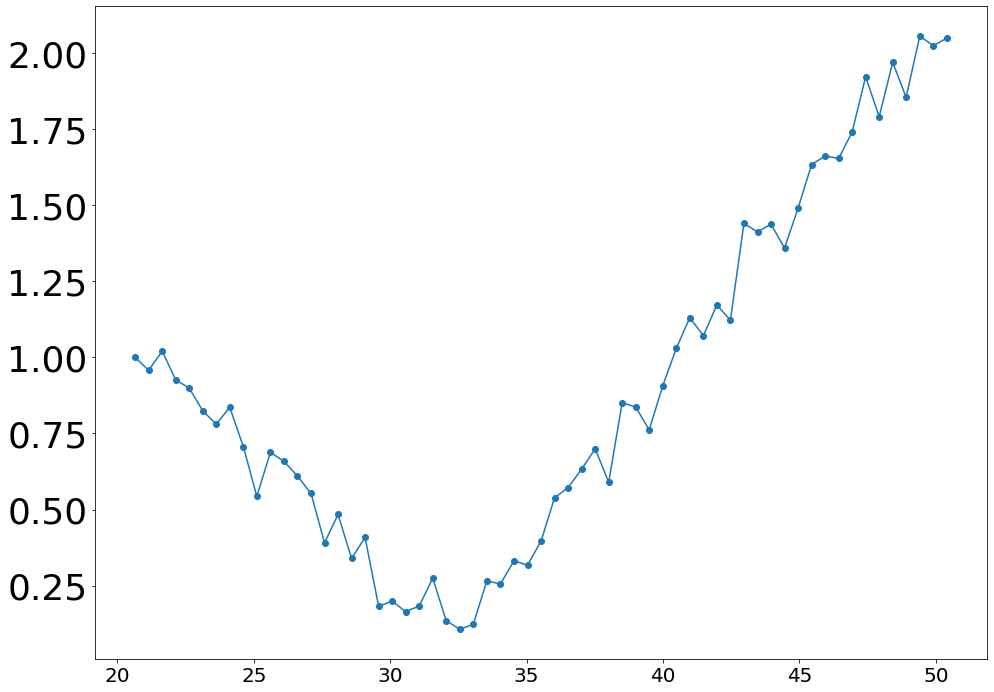

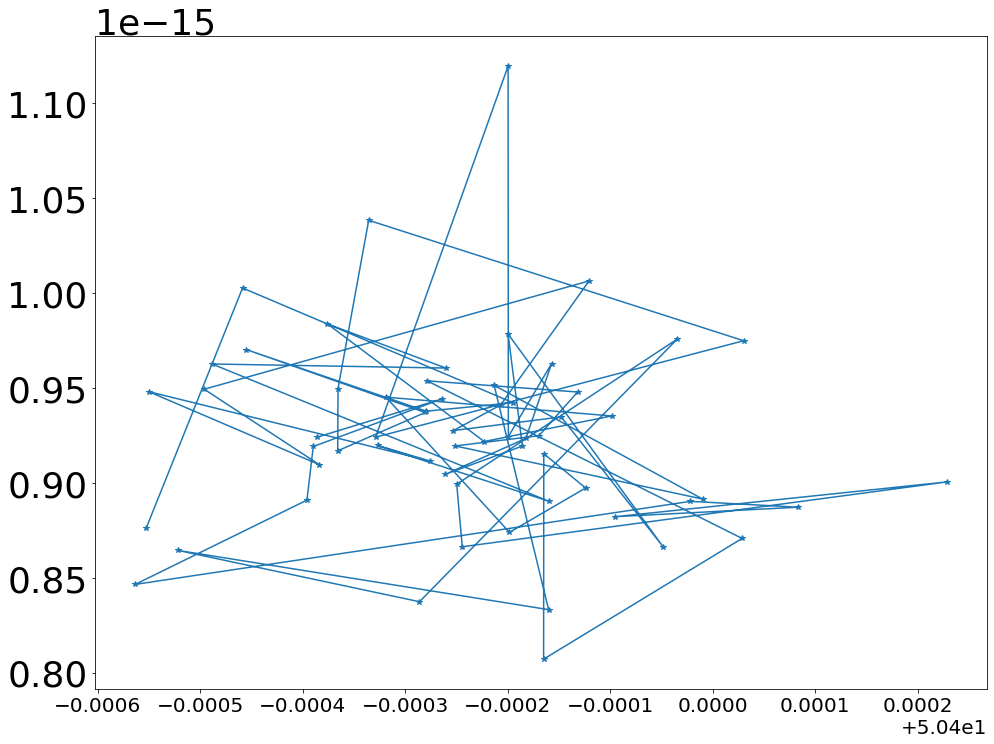

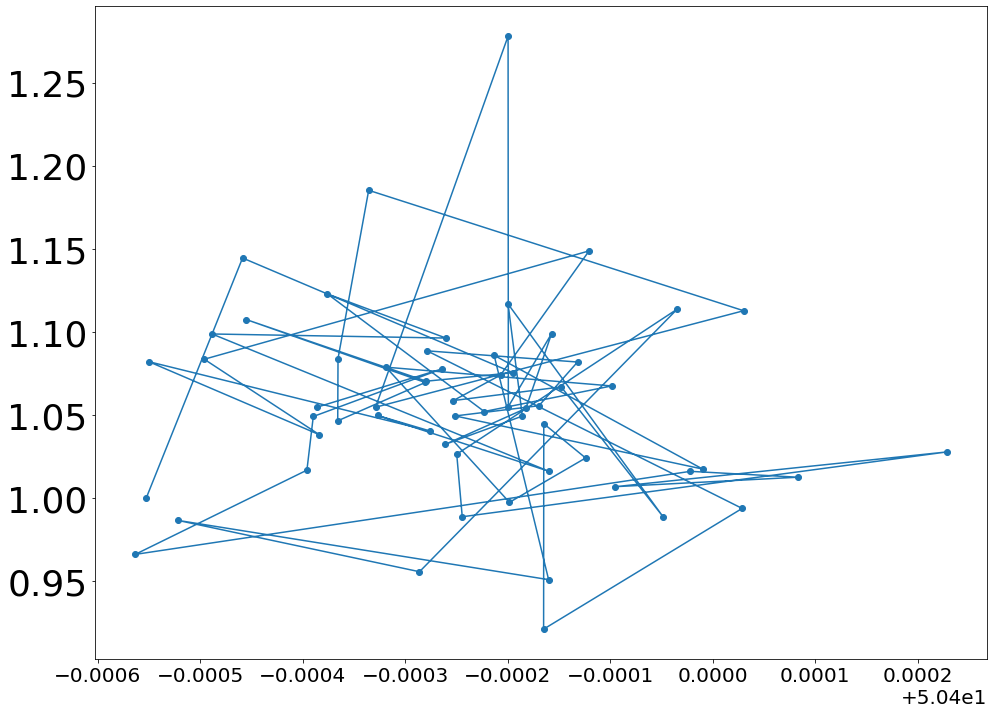

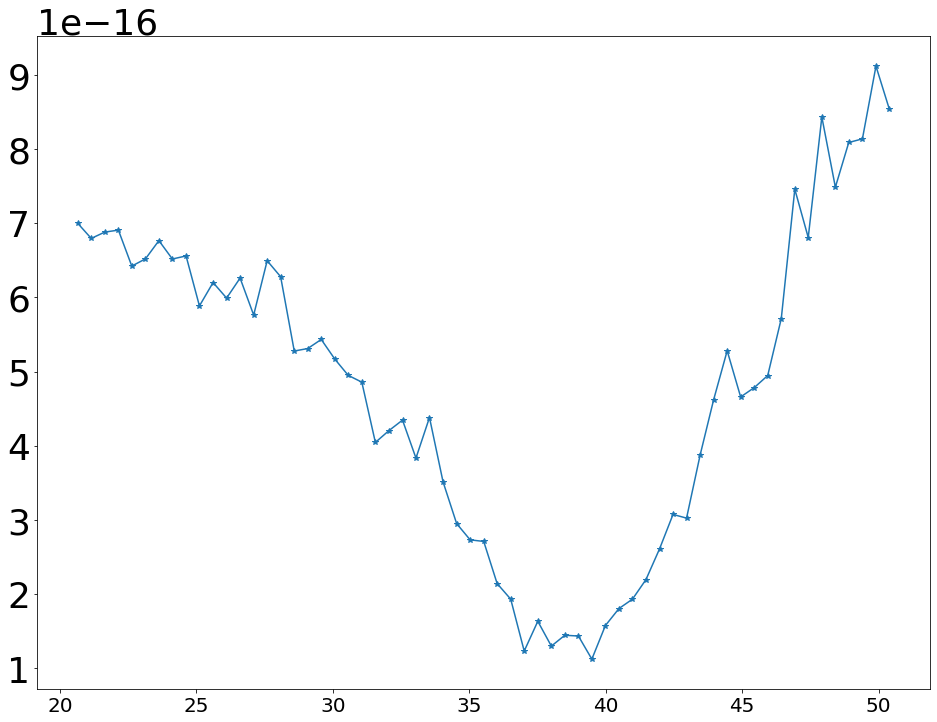

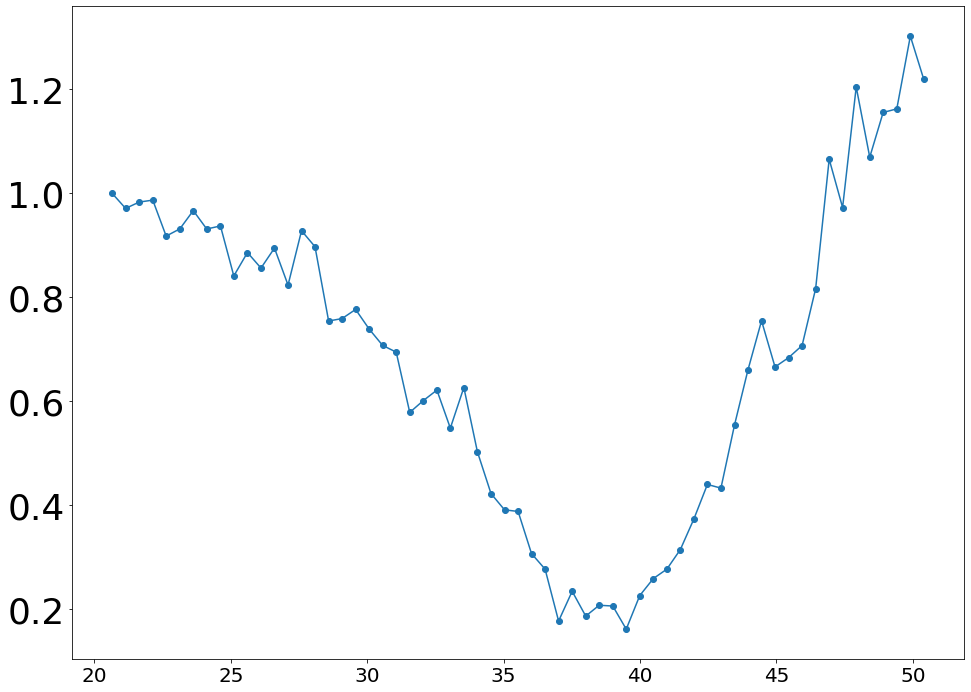

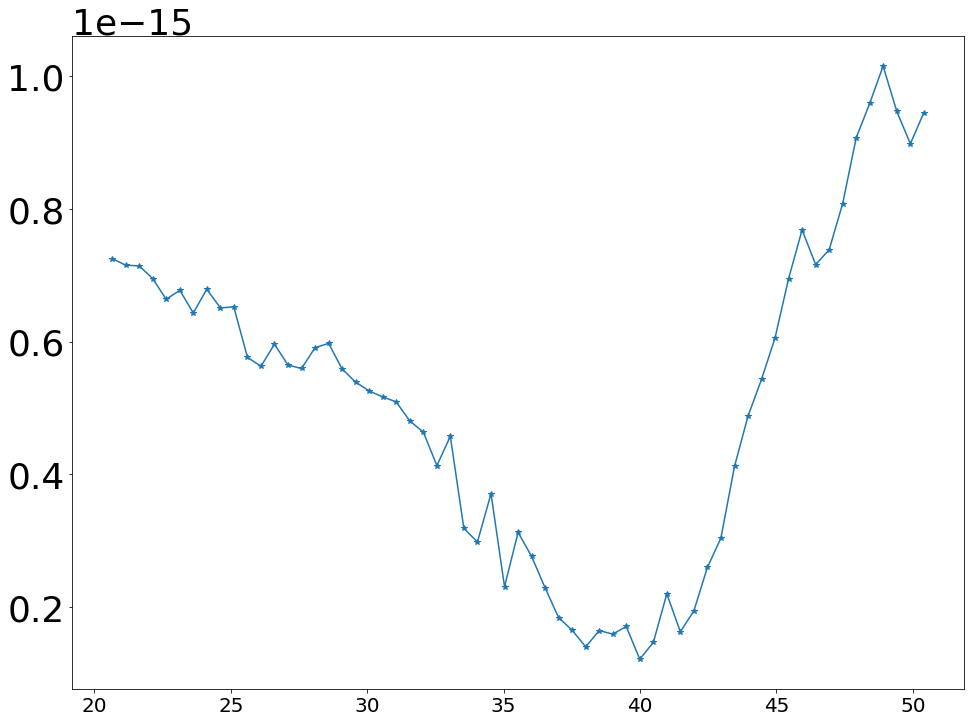

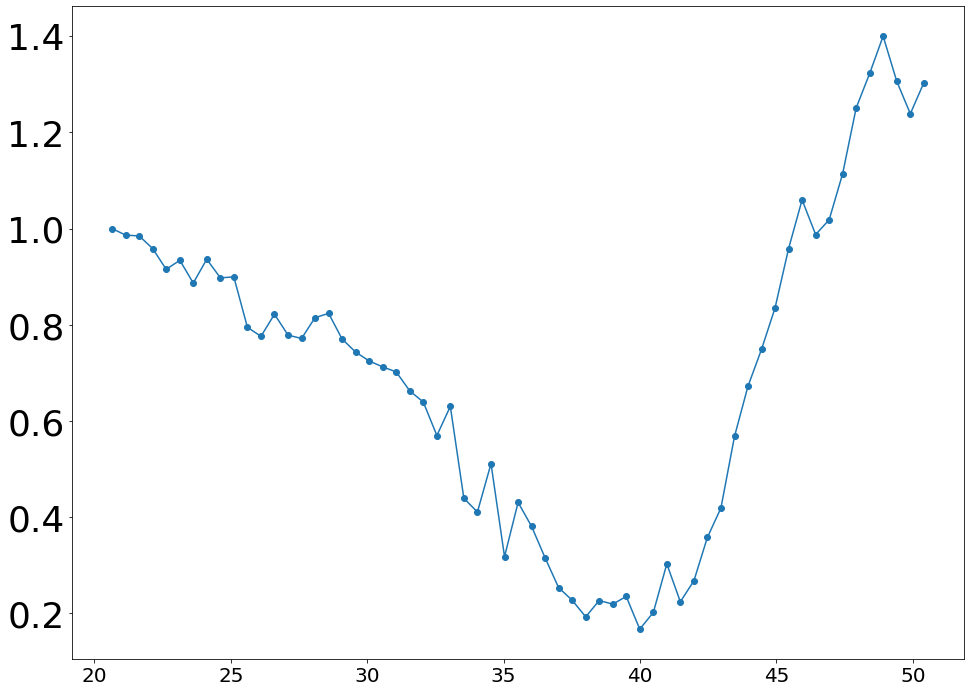

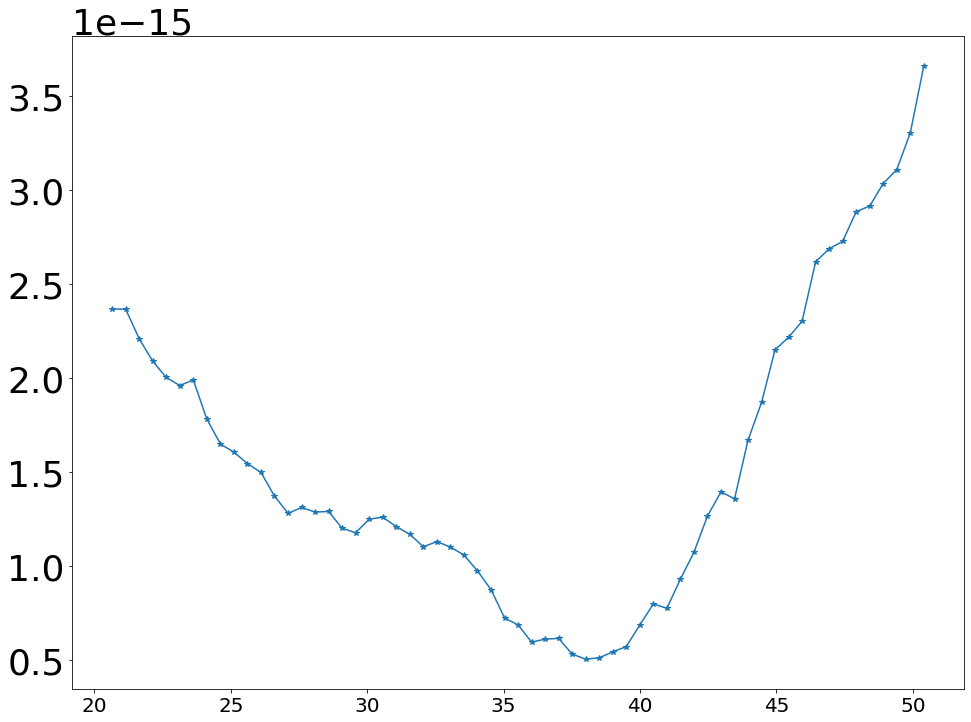

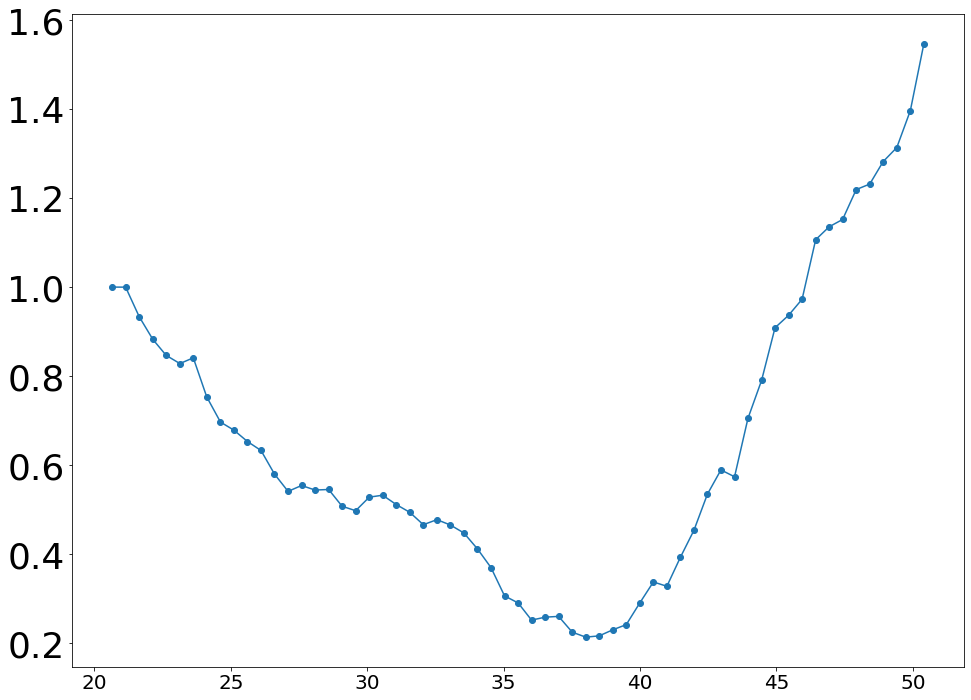

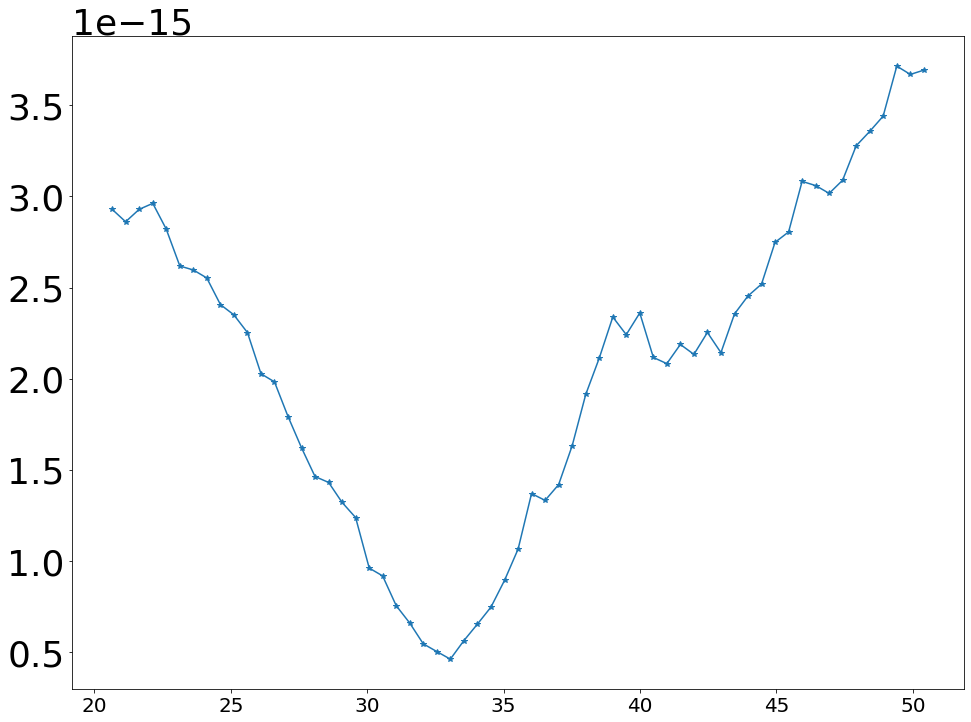

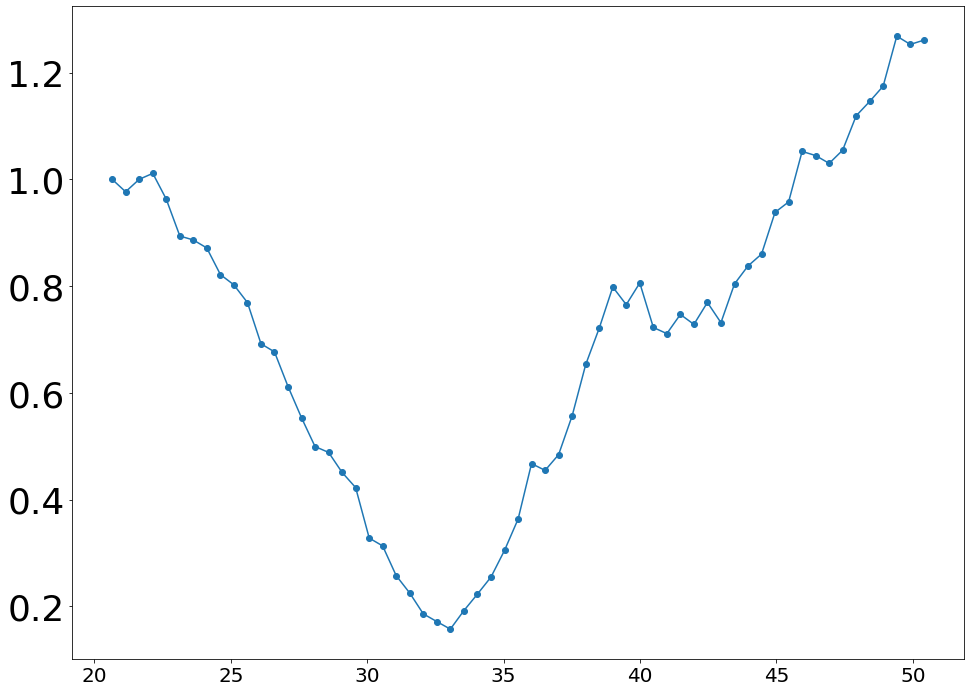

In [390]:
data = np.arange(0,30,1)
f = make_resp_plots(full_data_list,data,"z",151,force_norm=1/2.894433604871321e-19,plot=True)

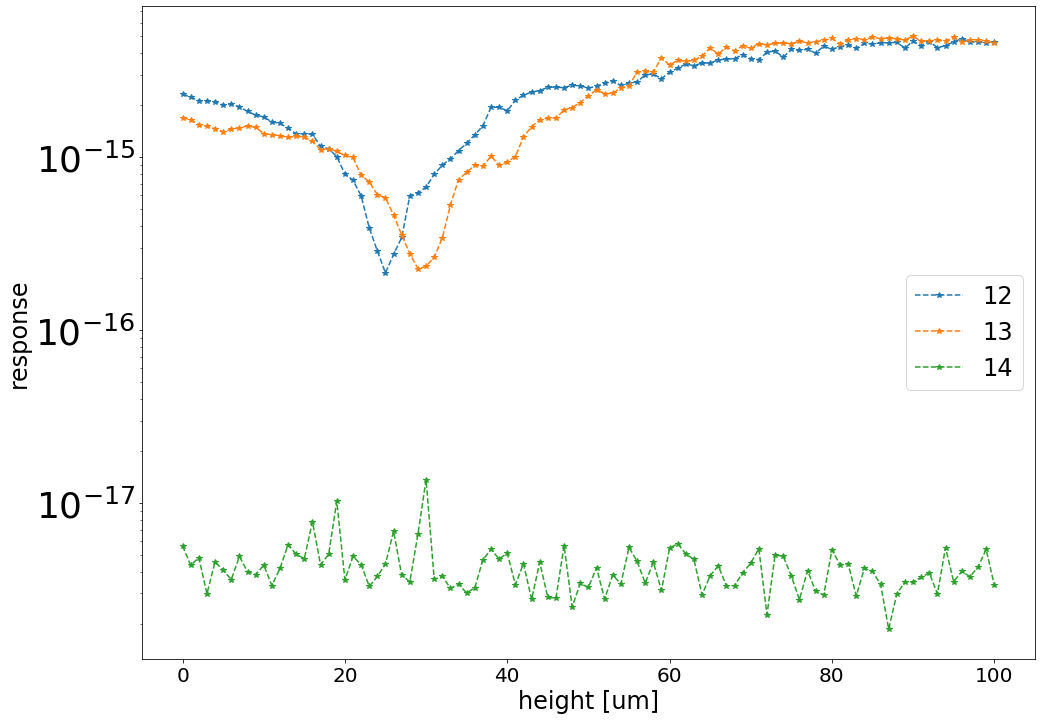

In [361]:
for i in range(len(f[0])):
    plt.plot(f[0][i],linestyle="--",marker="*", label = "%d" %(i+12))
plt.xlabel("height [um]")
plt.ylabel("response")
plt.yscale("log")
plt.legend()

In [231]:
def response_at_spin(bdf,drive_freq,bandwidth=0,first=0,last=0):
    x = [] 
    x = bdf.spin_data

    if last!=0:
        x = x[:last]
    if first!=0:
        x = x[first:]

    if (bandwidth==0):
        bandwidth = 1
    b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/(bdf.fsamp*10), 2.*(drive_freq+bandwidth/2.)/(bdf.fsamp*10) ], btype = 'bandpass')
    responsefilt = signal.filtfilt(b, a, x)
    return responsefilt    


def spin_height_response(bdfs, drive_freq,bandwidth=0,norm=True):   
    resp = [np.std(response_at_spin(file, drive_freq=drive_freq,bandwidth=bandwidth)) for file in bdfs]
    if(norm==True):
        norm = resp[0]
        resp = resp/norm    
    return resp




In [358]:
print(len(full_data_list[file][it].x2))
print(len(full_data_list[file][it].spin_data))

50000
50000


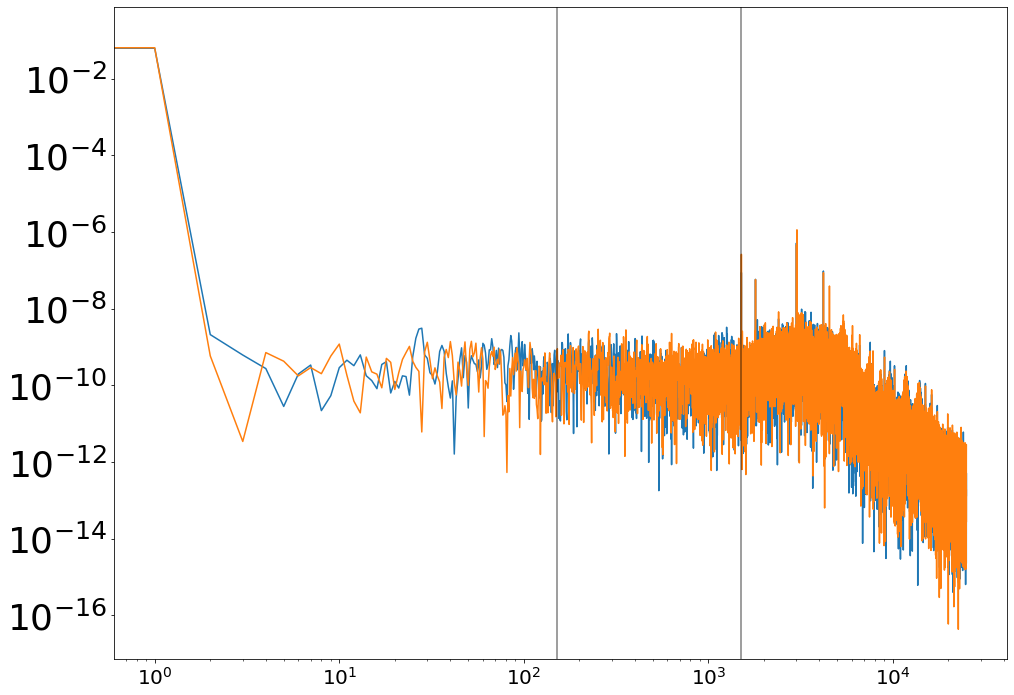

In [301]:
file = 22
it = 20
res = 50000
plt.loglog(full_data_list[file][it].welch_psd("spin",res)[0],full_data_list[file][it].welch_psd("spin",res)[1])
plt.loglog(full_data_list[file+1][it].welch_psd("spin",res)[0],full_data_list[file+1][it].welch_psd("spin",res)[1])
plt.axvline(151,alpha=0.5,color="black")
plt.axvline(1510,alpha=0.5,color="black")

#plt.ylim(1e-11,1e-8)

In [412]:
len(full_data_list[file][it].welch_psd("spin",res)[1])


25001

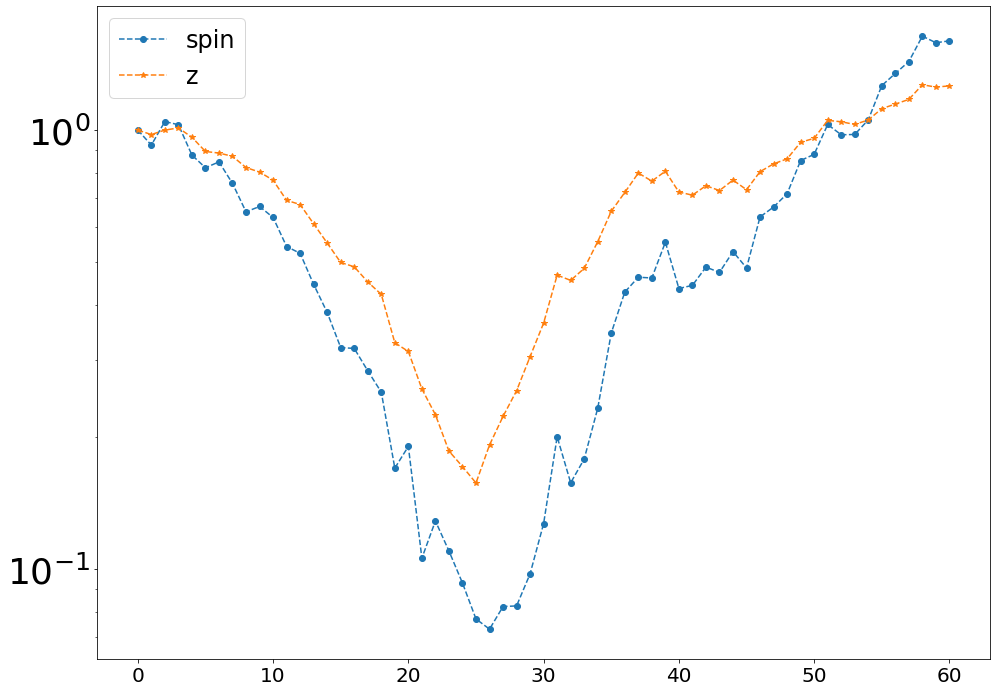

In [429]:
file = 29
#it = 20
res = 50000
sresp_list = []
for it in range(len(full_data_list[file])):
    sresp_list.append(full_data_list[file][it].welch_psd("spin",res)[1][1510])
plt.plot(sresp_list/sresp_list[0],linestyle="--",marker="o", label="spin")    
#plt.plot(sresp_list2/sresp_list2[0],linestyle="--",marker="o")    
plt.plot(f[0][file]/f[0][file][0],linestyle="--",marker="*", label = "z")
#plt.plot(f[0][2]/f[0][2][0],linestyle="--",marker="*", label = "%d" %(i+12))
plt.yscale("log")
plt.legend()

In [136]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy
import math 

def getphase(data, drive_freq, AO, fsamp):
	
	bandwidth = 1
	b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/fsamp, 2.*(drive_freq+bandwidth/2.)/fsamp], btype = 'bandpass')
	responsefilt = signal.filtfilt(b, a, data)
	
	fsamp = fsamp*1.0
    #drive_freq = drive_freq*1.0
	dd = float(drive_freq)
	points=int(fsamp/dd)*10
	t = np.linspace(0, 1/dd, points)
	optimize_func = lambda x: x[0]*np.sin(2*math.pi*dd*t+x[1]) + x[2] - responsefilt[:points]/np.max(responsefilt[:points])
	est_amp, est_phase, est_mean = scipy.optimize.leastsq(optimize_func, [2, 1, 0])[0]
	return est_phase, est_amp


def response(fname, drive_freq, AO):
	
	## load pos data
	f = h5py.File(fname,'r')
	pos_data = np.array(f['pos_data'])
	quad_data = np.array(f['quad_data'])
	fsamp = f.attrs['Fsamp']
	fsamp /= f.attrs['downsamp']

	i=2+AO//1
	## filterout response at a given frequancy
	x = pos_data.reshape(-1,11).T[i]
	
	## estimate xyz based on amp-phase
	amp = quad_data.reshape(-1,12).T[:5]
	phase = quad_data.reshape(-1,12).T[5:10]
	right = amp[0] + amp[1]
	left = amp[2] + amp[3]
	top = amp[0] + amp[2]
	bottom = amp[1] + amp[3]
	quad_sum = right+left
	x2 = (right-left)/quad_sum
	y2 = (top-bottom)/quad_sum
	z2 = phase[4]
	bandwidth = 1
	b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/fsamp, 2.*(drive_freq+bandwidth/2.)/fsamp], btype = 'bandpass')
	responsefilt = signal.filtfilt(b, a, x)
	responsefilt2=np.std(responsefilt)
	i=AO//1
	phase_variable, amp_variable = getphase(x2,drive_freq,0,fsamp)
	return responsefilt2,phase_variable,amp_variable

In [362]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy
import math 

def getphase(data, drive_freq, AO, fsamp):
	
	bandwidth = 1
	b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/fsamp, 2.*(drive_freq+bandwidth/2.)/fsamp], btype = 'bandpass')
	responsefilt = signal.filtfilt(b, a, data)
	
	fsamp = fsamp*1.0
    #drive_freq = drive_freq*1.0
	dd = float(drive_freq)
	points=int(fsamp/dd)*10
	t = np.linspace(0, 1/dd, points)
	optimize_func = lambda x: x[0]*np.sin(2*math.pi*dd*t+x[1]) + x[2] - responsefilt[:points]/np.max(responsefilt[:points])
	est_amp, est_phase, est_mean = scipy.optimize.leastsq(optimize_func, [2, 1, 0])[0]
	return est_phase, est_amp


def response(fname, drive_freq, AO):
	
	## load pos data
	f = h5py.File(fname,'r')
	pos_data = np.array(f['pos_data'])
	quad_data = np.array(f['quad_data'])
	fsamp = f.attrs['Fsamp']
	fsamp /= f.attrs['downsamp']

	i=2+AO//1
	## filterout response at a given frequancy
	x = pos_data.reshape(-1,11).T[i]
	
	## estimate xyz based on amp-phase
	amp = quad_data.reshape(-1,12).T[:5]
	phase = quad_data.reshape(-1,12).T[5:10]
	right = amp[0] + amp[1]
	left = amp[2] + amp[3]
	top = amp[0] + amp[2]
	bottom = amp[1] + amp[3]
	quad_sum = right+left
	x2 = (right-left)/quad_sum
	y2 = (top-bottom)/quad_sum
	z2 = phase[4]
	bandwidth = 1
	b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/fsamp, 2.*(drive_freq+bandwidth/2.)/fsamp], btype = 'bandpass')
	responsefilt = signal.filtfilt(b, a, x)
	responsefilt2=np.std(responsefilt)
	i=AO//1
	phase_variable, amp_variable = getphase(x2,drive_freq,0,fsamp)
	return responsefilt2,phase_variable,amp_variable

In [381]:
resp_list=[]
for j in np.arange(0,101,1):
    resp_list.append(response(folder+"/HeightProfile12_%d.h5" %j, 151,0))

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [382]:
resp_list[0][0]

7942014.685482878

In [383]:
resp_list


[(7942014.685482878, 0.9969103321776646, -0.0024058311339386212),
 (7667220.188000783, 0.782290528981715, -0.0018409707020339214),
 (7582606.885703655, 0.6196643323400927, -0.001601379326585966),
 (7877422.336266127, 0.9176167670909273, -0.0021511790281693224),
 (7845535.996978801, 0.6918255173363532, -0.0016894198727907123),
 (7836639.097143115, 0.9181760354122936, -0.0021553946222064055),
 (7941077.160812321, 1.0515287986338389, -0.0026366718378612753),
 (8162648.284148966, 0.8796043464636114, -0.002045761355674859),
 (8363771.767080172, 0.7587109261494337, -0.0017942292934692383),
 (8727881.260012012, 0.7497862401755092, -0.0017807647342356252),
 (8832832.931011904, 0.8903219533361122, -0.0020713080808387172),
 (8539914.165697033, 0.7792020609657201, -0.0018320631001773674),
 (8854676.456763234, 1.03247254116422, -0.002548137843900667),
 (9018998.073129242, 0.9502100406118702, -0.002241690726452139),
 (8977649.477895191, 0.9897230932013028, -0.0023767767484634463),
 (9032304.1278266

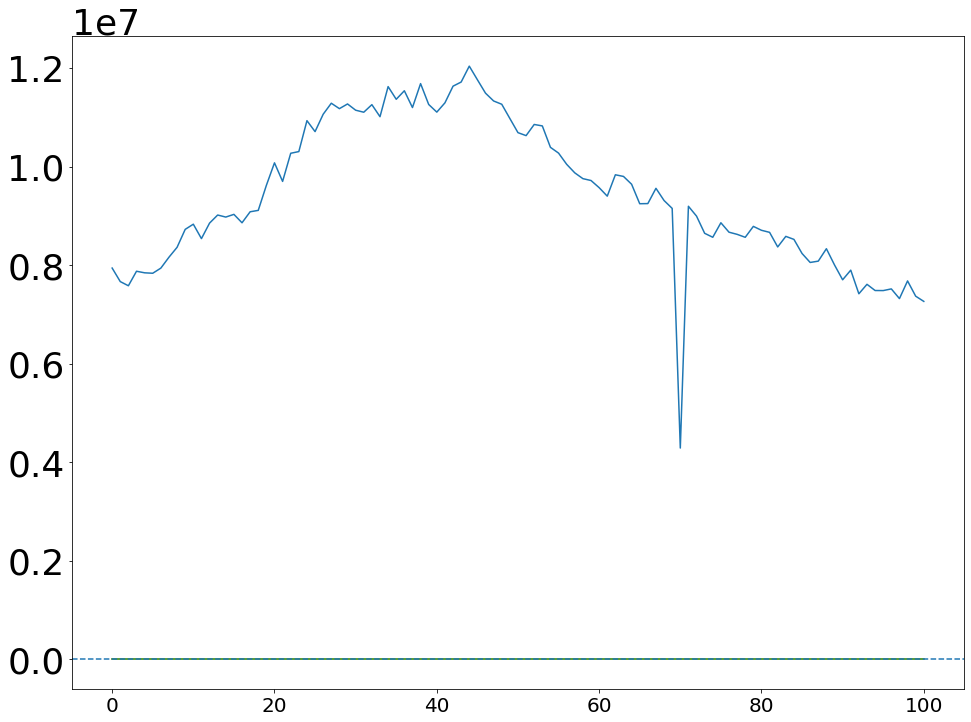

In [386]:
plt.plot(resp_list)
plt.axhline(0, linestyle="dashed")
#plt.ylim(-np.pi,np.pi)

In [378]:
fname = folder+"/HeightProfile12_0.h5" #folder+"/Bead"+str(BeadNumber)+"/Shaking"+"/Shaking%d_%d.h5" % (data_set,0)
BDF = BeadDataFile.BeadDataFile(fname)
data = BDF.xyz2
res = 50000
fsamp=5000
data_det=signal.detrend(data)
freqs=np.linspace(0,2500,(res/2)+1)    # change
xFFT=np.fft.rfft(data_det[0])
yFFT=np.fft.rfft(data_det[1])
zFFT=np.fft.rfft(data_det[2])
norm = np.sqrt(2 / (res* fsamp))
xpsd = norm**2 * (xFFT * xFFT.conj()).real
ypsd = norm**2 * (yFFT * yFFT.conj()).real
zpsd = norm**2 * (zFFT * zFFT.conj()).real

xnsd=np.sqrt(xpsd)
ynsd=np.sqrt(ypsd)
znsd=np.sqrt(zpsd)

xphase=np.angle(xFFT)
yphase=np.angle(yFFT)
zphase=np.angle(zFFT)


In [380]:
np.mean(zphase)

0.09226028034937743